# **REINFORCEMENT LEARNING FOR PORTFOLIO ALLOCATION**

In [23]:
#!pip install gymnasium
#!pip install quantstats
#!pip install stable_baselines3
#!pip install stable_baselines
#!pip install stockstats
#!pip install PyPortfolioOpt

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from typing import List

import yfinance as yf
import quantstats as qs
from stockstats import StockDataFrame as Sdf

from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

### OBJECTIVE AND CONSTRAINTS
Our objective is to **outperform** a ***benchmark*** strategy using *reinforcement* learning-based portfolio optimization model, designing the RL model to learn a policy that dynamically allocates *weights* to different assets with the goal of ***maximizing*** *returns* while considering the following constraints:  

*   **Daily Rebalancing**: capability to *adjust* the portfolio allocation among stocks on a *daily* basis.
*   **No Short Selling**: *non-negative* stock weights to be aligned with a ***long-only*** investment approach (no short positions in stocks).
*   **No commission Fees**: for the sake of modeling and analysis, we decide to evaluate the performance of the trading strategy ***without*** considering additional transaction *costs*.
*   **Total Weights Equal 1**: to maintain a ***normalized*** portfolio, ensuring that it is *fully invested*, and the weights of all stocks sum up to 1.

### FINANCIAL INDICATORS
For providing insights into market *trends* and potential trading *signals*, let's collect the following list of **financial** indicators:

* **MACD** (Moving Average Convergence Divergence): A trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

* **Bollinger Bands** (Upper Band and Lower Band): A volatility indicator that consists of a middle band being an N-period simple moving average, an upper band at K times an N-period standard deviation above the middle band, and a lower band at K times an N-period standard deviation below the middle band.

* **RSI** (Relative Strength Index): A momentum oscillator that measures the speed and change of price movements. RSI ranges from 0 to 100 and is typically used to identify overbought or oversold conditions.

* **CCI** (Commodity Channel Index): An oscillator used to identify cyclical turns in commodity prices. It measures the relationship between the current price, a moving average of prices, and normal deviations from that average.

* **DX** (Directional Movement Index): A trend strength indicator used to identify the strength and direction of a trend. It consists of the Plus Directional Movement (+DI), Minus Directional Movement (-DI), and Average Directional Index (ADX).

* **30-day Simple Moving Average** (close_30_sma): A popular indicator that smoothens out price data by creating a constantly updated average price.

* **60-day Simple Moving Average** (close_60_sma): Similar to the 30-day SMA, but calculated over a 60-day period.

In [25]:
INDICATORS = [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
]

# 1. DATA ENGINEERING

Let's construct the **data_split** and **data_split_percent** functions for splitting a DataFrame into training and testing sets based on date ranges:

In [26]:
def data_split(df, start_date, end_date, date_col = 'date'):
    df = (df
          .loc[(df[date_col] >= start_date) & (df[date_col] <= end_date)]
          .sort_values([date_col, 'tic'], ignore_index = True)                         # Sort the DataFrame based on date and 'tic' (ticker)
    )
    df.index = df[date_col].factorize()[0]                                             # Set a unique number index for every unique date using factorize
    return df

def data_split_percent(df, percent = 0.8, date_col = 'date'):
    df.index = df[date_col].factorize()[0]
    splitter = int(df.index[-1] * percent)                                             # Determine the index value for splitting based on the specified percentage
    train = df.loc[df.index <= splitter]
    test = df.loc[df.index > splitter]
    test.index = test[date_col].factorize()[0]
    return train, test

### SOURCE DATA

We decided to download data directly from **Yahoo Finance** instead of using the pre-prepared dataset containing only stock prices. Obtaining *real-time* or recent data directly from a financial *data source* might be more convenient:  

*   **Freshness of Data**: since financial markets are *dynamic* and stock prices can *change* rapidly, downloading data from Yahoo Finance allows you to access the most recent and **up-to-date** information.
*   **Inclusion of Additional Features**: Yahoo Finance provides a wide range of financial data and ***metrics*** behind stock prices, including company *fundamentals*, *technical* indicators, and *economic* indicators.
*   **Consistency Across Datasets**: by obtaining data directly from Yahoo Finance, you can ensure ***consistency*** with external *benchmarks* and *indices*.

In [27]:
class YFDownloader:
    def __init__(self):
        pass

    def download(self,
                 ticker_list: List[str], # for instance ['AAPL', 'MSFT']
                 start_date: str,
                 end_date: str,
                ) -> pd.DataFrame:

        # Initialize start and end dates
        self.start_date = start_date
        self.end_date = end_date

        # Initialize an empty DataFrame
        df = pd.DataFrame()

        # Iterate through the list of tickers
        for ticker in ticker_list:
            print(ticker)

            # Download data for the current ticker and assign a 'tic' column
            df_temp = (yf.download(ticker, start_date, end_date)
                          .assign(tic=ticker)
                      )

            # Concatenate the data for the current ticker to the main DataFrame
            df = pd.concat([df, df_temp])

        # Sort the DataFrame by index, reset the index, and rename columns to lowercase
        df = (df
              .sort_index()
              .reset_index()
              .rename(columns=lambda col: col.lower())
            )

        return df


Let's build the **DataPreprocessor** class designed to preprocess financial data, including cleaning, adding technical indicators, and generating variance-covariance matrices and returns:

In [28]:
class DataPreprocessor:
    def __init__(self,
                 tech_indicator_list=INDICATORS,
                 use_technical_indicators=True,
                 use_var_cov_matrix=True,
                 lookback_days=252,
                 ):
        self.tech_indicator_list = tech_indicator_list
        self.use_technical_indicators = use_technical_indicators
        self.use_var_cov_matrix = use_var_cov_matrix
        self.lookback_days = lookback_days

    def clean_data(self, df):
        df = (df
              .sort_values(['date', 'tic'])
              )
        return df

    def add_technical_indicator(self, data):
        df = data.copy()
        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    indicator_df = pd.concat(
                        [indicator_df, temp_indicator], axis=0, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(
                indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
            )
        df = df.sort_values(by=["date", "tic"])
        return df

    def add_var_cov_matrix(self, data):
        df = (data
              .sort_values(['date', 'tic'], ignore_index=True)
              .set_index(data.date.factorize()[0])  # now index is a unique number for every unique date
              )

        lookback = self.lookback_days
        var_cov_list = []
        returns_list = []
        for i in range(lookback, len(df.index.unique())):
            returns_lookback = (df
                                .loc[i - lookback:i, :]  # only rows we are looking back
                                .pivot_table(index='date', columns='tic', values='close')  # convert to df with columns date-tic1-tic2..
                                .pct_change()  # calculate returns
                                .dropna()
                                )
            var_covs = returns_lookback.cov().values  # variance-covariance matrix

            returns_list.append(returns_lookback)
            var_cov_list.append(var_covs)

        df_cov = pd.DataFrame({'date': df.date.unique()[lookback:],
                               'var_cov': var_cov_list, 'returns_list': returns_list})

        df = df.merge(df_cov, on='date')
        df = df.sort_values(['date', 'tic']).reset_index(drop=True)

        return df

    def preprocess_data(self, df):
        # 1. Clean Data
        df = self.clean_data(df)

        # 2. Add Technical Indicators (if needed)
        if self.use_technical_indicators:
            df = self.add_technical_indicator(df)

        # 3. Add var-cov matrix and returns
        if self.use_var_cov_matrix:
            df = self.add_var_cov_matrix(df)

        return df


# 2. DATA PREPROCESSING

For constructing a **well-balanced** and **resilient** investment portfolio, we decide to consider the following *well-known* companies: Microsoft Corporation (**MSFT**), Coca-Cola Company (**KO**), Boeing Company (**BA**), Procter & Gamble Co. (**PG**), AT&T Inc. (**T**), Pfizer Inc. (**PFE**), JPMorgan Chase & Co. (**JPM**), Exxon Mobil Corporation (**XOM**), McDonald's Corporation (**MCD**), Southern Company (**SO**), Simon Property Group, Inc. (**SPG**), and DuPont de Nemours, Inc. (**DD**).  

In [29]:
# Stock Tickers
stocks = ['MSFT', 'KO', 'BA', 'PG', 'T', 'PFE', 'JPM', 'XOM', 'MCD', 'SO', 'SPG', 'DD']

print(len(stocks))

12


Once created an instance of the *YFDownloader* class, let's download historical financial data for the specified list of stocks from **January 1, 2000**, to **November 30, 2023**:

In [30]:
# Download Historical Data
d = YFDownloader()
df2 = d.download(stocks, '2000-01-01', '2023-11-30')

MSFT


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KO
BA


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PG
T


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PFE
JPM


[*********************100%%**********************]  1 of 1 completed


XOM


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


MCD
SO


[*********************100%%**********************]  1 of 1 completed


SPG


[*********************100%%**********************]  1 of 1 completed


DD


[*********************100%%**********************]  1 of 1 completed


Before splitting the historical data, we decide to **preprocess** financial data, including *cleaning*, adding technical *indicators*, and generating *variance-covariance* matrices and *returns*:

In [31]:
# PreProcess Data
pr = DataPreprocessor(lookback_days = 21)
df3 = pr.preprocess_data(df2)
df3.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date       open       high        low      close  adj close   volume  \
0 2000-02-02  43.750000  45.187500  43.375000  44.625000  28.804611  3295500   
1 2000-02-02  56.456367  56.693577  53.758083  54.617977  25.481783  2853992   

  tic      macd    boll_ub    boll_lb     rsi_30      cci_30      dx_30  \
0  BA  0.190348  47.245200  41.711050  58.101333   15.678884  25.498446   
1  DD -1.571485  68.952286  52.442987  34.540133 -114.080600  30.728021   

   close_30_sma  close_60_sma  \
0     44.085227     44.085227   
1     60.821533     60.821533   

                                             var_cov  \
0  [[0.0007336240928770887, 5.556336209667598e-05...   
1  [[0.0007336240928770887, 5.556336209667598e-05...   

                                        returns_list  
0  tic               BA        DD       JPM      ...  
1  tic               BA        DD       JPM      ...

 Let's split the preprocessed dataframe such that the *training* set will contain ***80%*** of the data, and the *test* set will contain the remaining ***20%***:

In [32]:
# Split Data
train, test = data_split_percent(df3, percent = .8)
len(test.tic.value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12

In [33]:
train.head(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date   open     high     low   close  adj close   volume tic  \
0 2000-02-02  43.75  45.1875  43.375  44.625  28.804611  3295500  BA   

       macd  boll_ub   boll_lb     rsi_30     cci_30      dx_30  close_30_sma  \
0  0.190348  47.2452  41.71105  58.101333  15.678884  25.498446     44.085227   

   close_60_sma                                            var_cov  \
0     44.085227  [[0.0007336240928770887, 5.556336209667598e-05...   

                                        returns_list  
0  tic               BA        DD       JPM      ...

In [34]:
train.tail(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date   open       high        low      close  adj close    volume  \
4795 2019-02-26  78.68  79.129997  78.389999  78.660004  61.584389  10990600   

      tic      macd   boll_ub   boll_lb     rsi_30      cci_30      dx_30  \
4795  XOM  1.536029  80.20832  71.51368  57.819108  124.176854  13.786599   

      close_30_sma  close_60_sma  \
4795     74.494333     73.875833   

                                                var_cov  \
4795  [[0.0002956011902785907, 0.0001951625310156766...   

                                           returns_list  
4795  tic               BA        DD       JPM      ...

In [35]:
test.head(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date        open        high         low       close   adj close  \
0 2019-02-27  427.170013  436.329987  427.149994  435.440002  425.241302   

    volume tic       macd     boll_ub     boll_lb     rsi_30     cci_30  \
0  4603800  BA  17.431747  437.894002  383.175993  69.228353  112.73378   

      dx_30  close_30_sma  close_60_sma  \
0  37.50682    393.522664     360.79083   

                                             var_cov  \
0  [[0.00029605026731708466, 0.000188639628926713...   

                                        returns_list  
0  tic               BA        DD       JPM      ...

In [36]:
test.tail(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date        open        high         low       close   adj close  \
1198 2023-11-29  104.269997  104.580002  101.639999  102.339996  102.339996   

        volume  tic      macd     boll_ub     boll_lb     rsi_30     cci_30  \
1198  26802100  XOM -1.362062  107.801789  101.218211  42.330369 -91.285415   

          dx_30  close_30_sma  close_60_sma  \
1198  18.515535    105.951999       110.026   

                                                var_cov  \
1198  [[0.0002087751701531299, 2.6390555198123085e-0...   

                                           returns_list  
1198  tic               BA        DD       JPM      ...

In particular, *training* data collects observations from **February 02, 2000** to **February 26, 2019**, while the *test* set contains data from **February 27, 2019** to **November 29, 2023**.  

# 3. **BENCHMARK** STRATEGY

The goal is to leverage reinforcement learning to train models (**A2C** and **PPO**) that can dynamically allocates *weights* to different assets with the goal of ***maximizing*** *returns* and compare the performance of the RL-based algorithms against two *benchmark* strategies: equal weights (**EW**) strategy and the mean-variance optimization (**MMVO**) strategy.

## **EQUAL-WEIGHTS**

*   **Approach**: The equal weights strategy involves allocating an ***equal*** *percentage* of the portfolio to each asset. In other words, if there are *$N$* securities in the portfolio, each asset receives a weight of *$1/N$*.
*   **Objective**: The objective of this strategy is to maintain a ***balanced*** and ***diversified*** portfolio without favoring any specific asset. It assumes that each asset contributes *equally* to the overall portfolio.
*   **Implementation**: This strategy is *straightforward* to implement and does not require complex optimization. It provides a simple benchmark for comparing the performance of more sophisticated strategies.

The following **equal_weight_strategy_returns** performs the equal-weight optimization strategy on the *preprocessed* data:

In [37]:
def equal_weight_strategy_returns(df) ->pd.Series:
    """
    df: pandas dataframe with the following columns:
        data - open - high - low - close - tic
    """
    # Pivot the dataframe to have tickers as columns and dates as index
    pivot_df = df.pivot(index='date', columns='tic', values='close')

    # Calculate daily returns based on close prices
    daily_returns = pivot_df.pct_change().dropna()

    # Set equal weights for each asset in the portfolio
    weights = pd.DataFrame(1 / len(daily_returns.columns),
                      columns=daily_returns.columns,
                      index=daily_returns.index)
    print(weights.shape)

    # Calculate equal-weighted portfolio returns
    ew_portfolio_returns = (daily_returns*weights).sum(axis=1)
    return ew_portfolio_returns, weights

ew_portfolio_returns, ew_weights = equal_weight_strategy_returns(test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1198, 12)


In particular:

*   Create the new **pivot_df**, where each *column* represents the ***closing*** prices of a specific asset.
*   Calculate the **daily_returns** based on the *close* prices using the **pct_change()** method: it computes the percentage *change* between *consecutive* rows and drops the first row cointaining NaN values.
*   Set **equal weights** to each asset in the portfolio. In the new **weigths** dataframe, each *column* represents *assets* and each *row* represents a specific *date*. Each weight is set to **1** divided by the **total** number of assets.
*   The **ew_portfolio_returns** series represents the *daily* returns of the equal-weighted portfolio. The *returns* are calculated by multipling the ***daily returns*** by the ***weights*** and summing across columns.  



## **MMVO**

*   **Approach**: Modern Portfolio Theory, developed by *Harry Markowitz*, is based on the idea of achieving an optimal *risk-return* ***trade-off*** by combining assets in a portfolio. MPT considers the **correlation** between assets and aims to find an allocation that ***maximizes*** the expected *return* for a given level of *risk* (or minimizes risk for a given level of return).
*   **Objective**: The goal is to create a portfolio that offers the **highest** possible expected *return* for a given level of *risk* or the lowest possible risk for a given level of expected return.
*   **Implementation**: This strategy involves calculating the expected *returns*, *variances*, and *covariances* of assets to construct an **efficient frontier** of portfolios. The *optimal* portfolio is then selected based on the investor's ***risk tolerance*** and return expectations.

Let's compute the portfolio *performance* ***metrics***, including the expected return, volatility, and sharpe ratio:

In [38]:
# Extract price data from the training set
price_data = train.pivot_table(index='date', columns='tic', values='close')

# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(price_data)
S = risk_models.sample_cov(price_data)

# Create an EfficientFrontier instance
ef = EfficientFrontier(mu, S)

# Optimize for maximum Sharpe ratio
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Display portfolio performance metrics
ef.portfolio_performance(verbose=True)
print(cleaned_weights)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Expected annual return: 10.1%
Annual volatility: 18.6%
Sharpe Ratio: 0.43
OrderedDict([('BA', 0.32788), ('DD', 0.0), ('JPM', 0.0), ('KO', 0.0), ('MCD', 0.31981), ('MSFT', 0.0), ('PFE', 0.0), ('PG', 0.0), ('SO', 0.19343), ('SPG', 0.15889), ('T', 0.0), ('XOM', 0.0)])


Let's *transform* ***test*** data and calculate ***daily*** *returns:*

In [39]:
# Transforming the test data
test_price_data = test.pivot_table(index='date', columns='tic', values='close')

# Calculate daily returns from the test data
daily_returns = test_price_data.pct_change()

# Apply the optimized weights to calculate portfolio returns
portfolio_returns = daily_returns.dot(pd.Series(cleaned_weights))

# Create a Pandas Series to store portfolio returns
portfolio_performance_series = pd.Series(portfolio_returns, index=daily_returns.index)

# Display the series
portfolio_performance_series = portfolio_performance_series.fillna(0)

# Display portfolio performance metrics for the testing phase
ef.portfolio_performance(verbose=True)

Expected annual return: 10.1%
Annual volatility: 18.6%
Sharpe Ratio: 0.43


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.1008200039174453, 0.18583011255425752, 0.4349133883984921)

Therefore, let's plot the **efficient frontier** with *asset* points and *tangency* portfolio (maximum sharpe ratio):

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


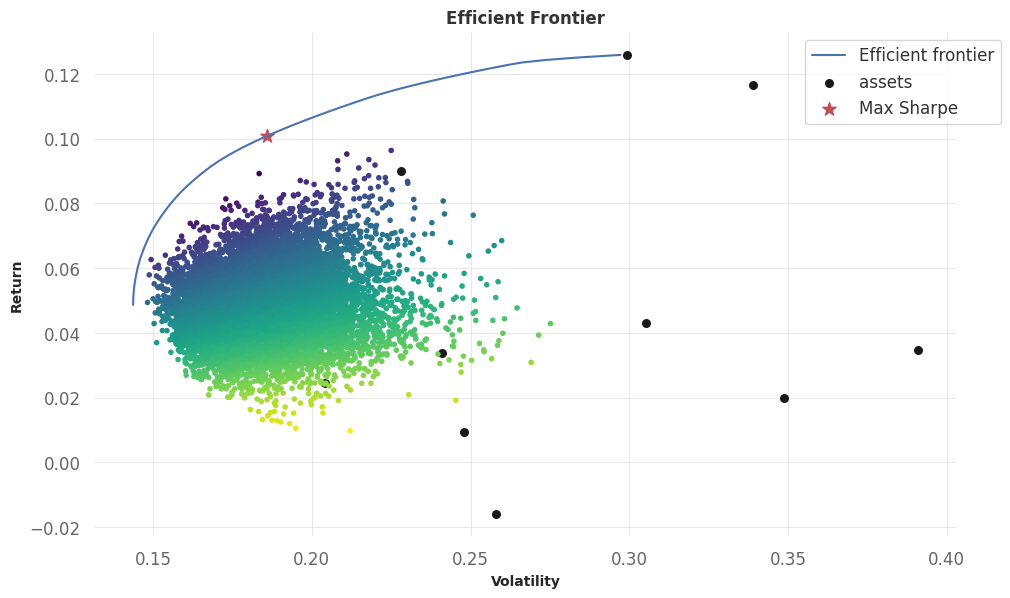

In [40]:
# Create a new EfficientFrontier instance for plotting
ef_for_plotting = EfficientFrontier(mu, S)

# Plotting code
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()

# Plot the efficient frontier with asset points
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)

# Find the tangency portfolio on the efficient frontier and plot it
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate and plot random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.set_title('Efficient Frontier', fontweight = 'bold', fontsize = 12)
ax.set_xlabel('Volatility', fontweight = 'bold', fontsize = 10)
ax.set_ylabel('Return', fontweight = 'bold', fontsize = 10)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.06, 1))

plt.show()

### *Trading*

Let's now perform **Mean-Variance** Portfolio Optimization for each time period in the *test set:*

In [41]:
# Extract price data from the preprocessed dataset
price_data = df3.pivot_table(index='date', columns='tic', values='close')
# Data Length Calculation
test_data_len = int(len(test) / len(stocks) )
train_data_len = int(len(train) / len(stocks))
print(f'Test data length: {test_data_len}')
print(f'Train data length: {train_data_len}')

cleaned_weights_list = []
for i in range(test_data_len):
    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(price_data[i:train_data_len+i] )
    S = risk_models.sample_cov(price_data[i:train_data_len+i])

    # Create an EfficientFrontier instance
    ef = EfficientFrontier(mu, S)

    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    cleaned_weights_list.append(cleaned_weights)

weights_df = pd.DataFrame(cleaned_weights_list, index= daily_returns.index)
weights_df

Test data length: 1199
Train data length: 4796


BA   DD  JPM   KO      MCD     MSFT  PFE   PG       SO  \
date                                                                      
2019-02-27  0.32788  0.0  0.0  0.0  0.31981  0.00000  0.0  0.0  0.19343   
2019-02-28  0.33851  0.0  0.0  0.0  0.31835  0.00000  0.0  0.0  0.20013   
2019-03-01  0.33168  0.0  0.0  0.0  0.31134  0.00000  0.0  0.0  0.21964   
2019-03-04  0.34704  0.0  0.0  0.0  0.31011  0.00000  0.0  0.0  0.21919   
2019-03-05  0.35995  0.0  0.0  0.0  0.28079  0.00000  0.0  0.0  0.22679   
...             ...  ...  ...  ...      ...      ...  ...  ...      ...   
2023-11-22  0.00000  0.0  0.0  0.0  0.66466  0.33534  0.0  0.0  0.00000   
2023-11-24  0.00000  0.0  0.0  0.0  0.66439  0.33561  0.0  0.0  0.00000   
2023-11-27  0.00000  0.0  0.0  0.0  0.66375  0.33625  0.0  0.0  0.00000   
2023-11-28  0.00000  0.0  0.0  0.0  0.66017  0.33983  0.0  0.0  0.00000   
2023-11-29  0.00000  0.0  0.0  0.0  0.66235  0.33765  0.0  0.0  0.00000   

                SPG    T  XOM  
date                           
2019-02-27  0.15889  0.0  0.0  
2019-02-28  0.14300  0.0  0.0  
2019-03-01  0.13734  0.0  0.0  
2019-03-04  0.12365  0.0  0.0  
2019-03-05  0.13247  0.0  0.0  
...             ...  ...  ...  
2023-11-22  0.00000  0.0  0.0  
2023-11-24  0.00000  0.0  0.0  
2023-11-27  0.00000  0.0  0.0  
2023-11-28  0.00000  0.0  0.0  
2023-11-29  0.00000  0.0  0.0  

[1199 rows x 12 columns]

In [42]:
test_price_data = price_data[train_data_len-1:]
len(test_price_data)

# Calculate daily returns based on close price
daily_returns = test_price_data.pct_change().dropna()
daily_returns.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tic               BA        DD       JPM        KO       MCD      MSFT  \
date                                                                     
2019-02-27  0.020315 -0.020759 -0.001235  0.005594  0.000819 -0.001691   
2019-02-28  0.010380 -0.027230 -0.007607  0.008901  0.002618 -0.001248   

tic              PFE        PG        SO       SPG         T       XOM  
date                                                                    
2019-02-27 -0.002092 -0.009216  0.003251 -0.011130 -0.005125  0.010297  
2019-02-28  0.009783 -0.003640  0.006278 -0.000441  0.001932 -0.005537

Therefore, let's apply the Modern Portfolio Theory (**MPT**) *weights* to the *daily returns* of individual assets to calculate the ***daily portfolio*** returns:

In [43]:
# Calculate Portfolio Returns
portfolio_returns_mpt = daily_returns * weights_df
# Calculate Overall Portfolio Performance
portfolio_performance_series = portfolio_returns_mpt.sum(axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4. **RL** ALGORITHM

In order to **outperform** the *benchmark* strategies, we decided to use reinforcement learning-based models, including **Actor Critic** and Proximal Policy Optimization (**PPO**).

RL-based models can be useful for portfolio optimization purposes due to several advantages:
- **Adaptability to Dynamic Markets**: RL models excel at *adapting* to new information and evolving market dynamics, learning and *adjusting* portfolio strategies based on changing trends and conditions.
- **Non-Linearity and Complex Patterns**: RL models can capture *non-linear* patterns and complex relationships in financial data.
- **Exploration-Exploitation Tradeoff**: RL addresses the exploration-exploitation tradeoff. It allows the model to *explore* different portfolio strategies to *discover* optimal actions while also *exploiting* known strategies to *maximize* cumulative returns.
- **Risk Management**: RL models can integrate risk management strategies into the optimization process. They can *dynamically* adjust portfolio weights to control exposure to *high-risk* assets, optimize the *trade-off* between risk and return, and adapt to changing risk conditions.
- **Reduced Reliance on Assumptions**: RL-based models can *learn* directly from data, *reducing* the need for making strong assumptions about the underlying distribution of financial returns.


## **Actor Critic**

### *Data Engeneering*

The following **PortfolioEnv** class is an OpenAI Gym environment designed for portfolio management reinforcement learning. It simulates a portfolio's performance over time based on historical financial data and allows an agent to take actions (portfolio weight adjustments) to maximize its cumulative return:

In [44]:
class PortfolioEnv(gym.Env):
    def __init__(self, df, initial_investment, tech_indicators=INDICATORS, day=0, lookback=252):
        # Initialization
        self.day = day
        self.df = df
        self.tech_indicators = tech_indicators
        self.initial_investment = initial_investment
        self.lookback = lookback

        # Action and observation spaces
        self.nstocks = len(df['tic'].unique())
        self.action_space = spaces.Box(low=0, high=1, shape=(self.nstocks,))              # action_space represents portfolio weights for each stock
        self.observation_space = spaces.Box(                                              # observation_space consists of a covariance matrix and technical indicators
            low=-np.inf,
            high=np.inf,
            shape=(self.nstocks + len(self.tech_indicators), self.nstocks),
        )

        # Internal variables
        self.data = df.loc[self.day, :]
        self.covs = self.data['var_cov'].values[0]
        self.state = np.append(
            np.array(self.covs),
            [self.data[tech].values.tolist() for tech in self.tech_indicators],
            axis=0,
        )
        self.terminal = False

        # Portfolio performance metrics
        self.portfolio_value = self.initial_investment
        self.asset_memory = [self.initial_investment]
        self.portfolio_return_memory = [0]
        self.actions_memory = [np.array([1 / self.nstocks] * self.nstocks)]
        self.date_memory = [self.data.date.unique()[0]]

    def step(self, actions, verbose=False):
        # Environment step
        if verbose:
            print(f'Day: {self.day}')
            print(f'Number of unique days: {len(self.df.index.unique())}')
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        if self.terminal:
            # Calculate and print performance metrics at the end of the simulation
            df = pd.DataFrame(self.portfolio_return_memory, columns=['daily_return'])

            if df.daily_return.std() > 0 or df.daily_return.std() < 0:
                sharpe = (
                    (252 ** 0.5)
                    * df.daily_return.mean()
                    / df.daily_return.std()
                )
                print(f'Sharpe Ratio: {sharpe:.3f}')

            print('============================================')
            print('Simulation completed!')
            print(f'Initial portfolio value: {self.asset_memory[0]}')
            print(f'Final portfolio value: {self.portfolio_value}')
            print('============================================')

            return self.state, self.reward, self.terminal, False, {}

        else:
            # Update portfolio based on actions (weights)
            weights = self.softmax_normalization(actions)
            if verbose:
                print(f'Normalized weights: {weights}')
            self.actions_memory.append(weights)
            last_day_memory = self.data

            # Load next state
            self.day += 1
            self.data = self.df.loc[self.day, :]
            self.covs = self.data['var_cov'].values[0]
            self.state = np.append(
                np.array(self.covs),
                [self.data[tech].values.tolist() for tech in self.tech_indicators],
                axis=0,
            )

            # Calculate portfolio returns
            portfolio_return = sum(
                (self.data.close.values / last_day_memory.close.values - 1) * weights
            )

            if verbose:
                print(f'Portfolio Return: {portfolio_return:.2f}')

            # Update portfolio value
            self.portfolio_value *= (portfolio_return + 1)
            if verbose:
                print(f'New portfolio value: {self.portfolio_value:.2f}')

            # Save portfolio information
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(self.portfolio_value)

            # Reward is the new portfolio value
            self.reward = self.portfolio_value

            return self.state, self.reward, self.terminal, False, {}

    def reset(self, seed=None):
        # Reset the environment to the initial state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.covs = self.data['var_cov'].values[0]
        self.state = np.append(
            np.array(self.covs),
            [self.data[tech].values.tolist() for tech in self.tech_indicators],
            axis=0,
        )
        self.asset_memory = [self.initial_investment]
        self.portfolio_value = self.initial_investment
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory = [np.array([1 / self.nstocks] * self.nstocks)]
        self.date_memory = [self.data.date.unique()[0]]

        return self.state, {}

    def softmax_normalization(self, actions):
        """
        Transform a vector to a probability distribution using softmax normalization
        """
        return np.exp(actions) / np.sum(np.exp(actions))

    def save_asset_memory(self):
        # Save portfolio return information
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_portfolio_value = pd.DataFrame(
            {'date': date_list, 'daily_return': portfolio_return}
        )
        return df_portfolio_value

    def save_action_memory(self):
        # Save portfolio weights at each step
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list, columns=['date'])
        action_list = self.actions_memory
        df_actions = pd.DataFrame(
            action_list, columns=self.data.tic.values, index=df_date.date
        )
        return df_actions

    def get_sb_env(self):
        # Get the gym environment for Stable-Baselines training
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [45]:
# Perform One Step with a set of actions (weights)
env_mytest = PortfolioEnv(train, initial_investment = 1000)
env_mytest.reset()
env_mytest.step([0.5]*len(stocks), verbose=True)
env_mytest.save_asset_memory()
env_mytest.state.shape

Day: 0
Number of unique days: 4796
Normalized weights: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
Portfolio Return: -0.01
New portfolio value: 994.29


(20, 12)

In [46]:
state_space = len(train.tic.unique())
env = PortfolioEnv(train, initial_investment = 1000, )
env_train, _ = env.get_sb_env()
type(env_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv

The following **TensorboardCallback** class is a custom callback for use with reinforcement learning training using the Stable-Baselines library. Callbacks in reinforcement learning are functions that are executed at specific points during training, allowing for custom actions or monitoring.

In this specific callback, it is designed to work with the **A2C** (Advantage Actor-Critic) gradient-based algorithm:

In [47]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            # Attempt to record the training reward from the local dictionary
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

        except BaseException as error:
            try:
                # If "rewards" is not found, attempt to record "reward"
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)

        return True

Using the Stable-Baselines library, the **DRLAgent** class defines methods for obtaining, training, and making predictions with a specified reinforcement learning model:

In [48]:
class DRLAgent:
    def __init__(self, env):
        self.env = env

    def get_model(self, model_name, model_kwargs, policy='MlpPolicy', tensorboard_log=None, verbose=1,
                 policy_kwargs=None, seed=None):
        return A2C(
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    @staticmethod
    def train_model(model, tb_log_name, total_timesteps=5000):
        '''
        This function is a static method, so it can be called without creating an instance of the class
        '''
        model = model.learn(
            tb_log_name=tb_log_name,
            total_timesteps=total_timesteps,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        account_memory = None
        actions_memory = None
        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            test_obs, rewards, dones, info = test_env.step(action)

            if (i == max_steps - 1):
                account_memory = test_env.env_method(method_name='save_asset_memory')
                actions_memory = test_env.env_method(method_name="save_action_memory")

            if dones[0]:
                print('The End!')
                break
        return account_memory[0], actions_memory[0]

### *Training*

In [49]:
agent = DRLAgent(env = env_train)
# A2C_PARAMS = {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
A2C_PARAMS = {'n_steps': 5, 'ent_coef': 0.009, 'learning_rate': 0.0008}
# best so far: 5, 0.009, 0.0008

model_a2c = agent.get_model(model_name='a2c', model_kwargs=A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c')

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 292      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -17      |
|    explained_variance | 6.02e-06 |
|    learning_rate      | 0.0008   |
|    n_updates          | 99       |
|    policy_loss        | 5.34e+04 |
|    reward             | 941.0289 |
|    std                | 0.996    |
|    value_loss         | 9.18e+06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 306      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -16.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0008   |
|    n_updates       

### *Trading*

In [50]:
env_trade = PortfolioEnv(test, initial_investment=1000)
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment=env_trade)
df_actions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sharpe Ratio: 0.322
Simulation completed!
Initial portfolio value: 1000
Final portfolio value: 1253.982299492518
The End!


BA        DD       JPM        KO       MCD      MSFT  \
date                                                                     
2019-02-27  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333   
2019-02-28  0.137694  0.050655  0.137694  0.137694  0.050655  0.050655   
2019-03-01  0.137691  0.050654  0.137691  0.137691  0.050654  0.050654   
2019-03-04  0.137693  0.050655  0.137693  0.137693  0.050655  0.050655   
2019-03-05  0.137695  0.050655  0.137695  0.137695  0.050655  0.050655   
...              ...       ...       ...       ...       ...       ...   
2023-11-22  0.134202  0.049370  0.134202  0.134202  0.049370  0.049370   
2023-11-24  0.134191  0.049366  0.134191  0.134191  0.049366  0.049366   
2023-11-27  0.133432  0.049087  0.133432  0.133432  0.049087  0.049087   
2023-11-28  0.134192  0.049366  0.134192  0.134192  0.049366  0.049366   
2023-11-29  0.134410  0.049447  0.134410  0.134410  0.049447  0.049447   

                 PFE        PG        SO       SPG         T       XOM  
date                                                                    
2019-02-27  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333  
2019-02-28  0.050655  0.050655  0.103849  0.050655  0.073575  0.105563  
2019-03-01  0.050654  0.050654  0.103853  0.050654  0.073594  0.105557  
2019-03-04  0.050655  0.050655  0.103851  0.050655  0.073580  0.105561  
2019-03-05  0.050655  0.050655  0.103845  0.050655  0.073576  0.105564  
...              ...       ...       ...       ...       ...       ...  
2023-11-22  0.049370  0.049370  0.115180  0.049370  0.075582  0.110413  
2023-11-24  0.049366  0.049366  0.115248  0.049366  0.075450  0.110532  
2023-11-27  0.049087  0.049087  0.118337  0.049087  0.075659  0.111188  
2023-11-28  0.049366  0.049366  0.115238  0.049366  0.075478  0.110509  
2023-11-29  0.049447  0.049447  0.115028  0.049447  0.074566  0.110495  

[1199 rows x 12 columns]

Let's visualize **how** the portfolio is **allocated** across different *assets* over time:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


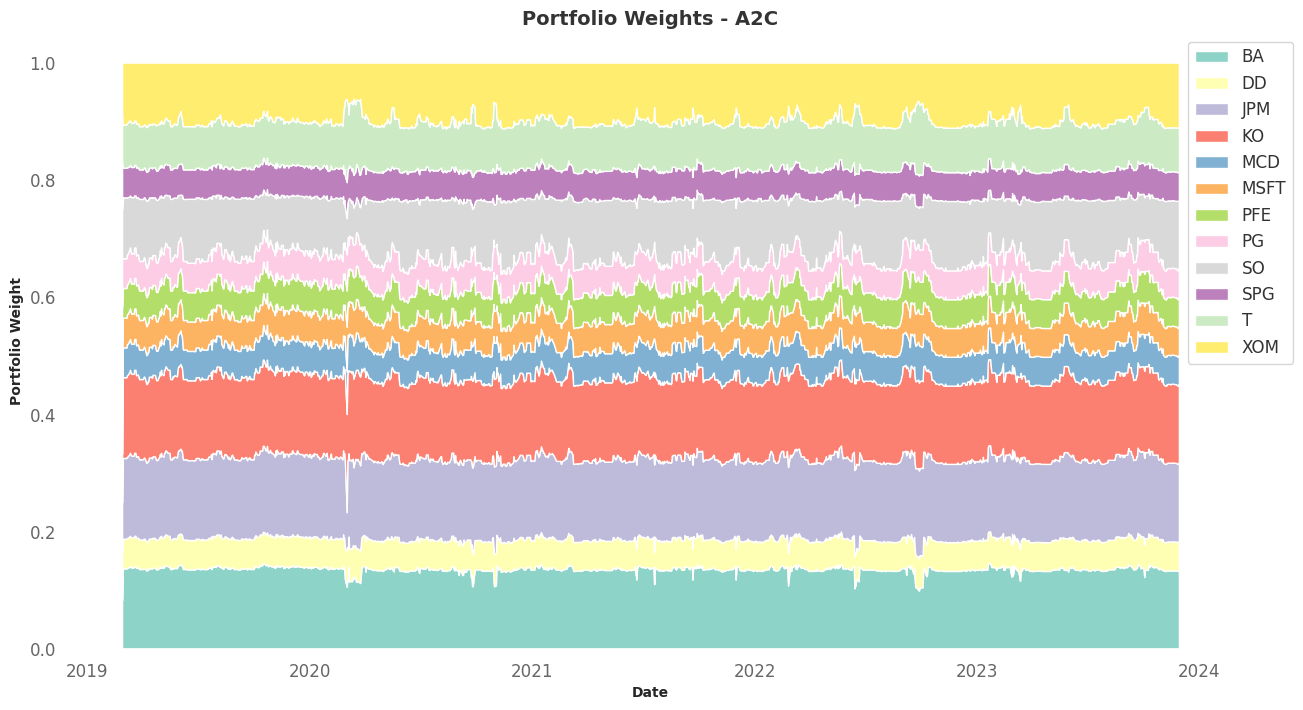

In [51]:
# Portfolio Weights - A2C
plt.figure(figsize = (15, 8))
colors = sns.color_palette("Set3", len(df_actions.columns))  # or "husl", "paired"

plt.stackplot(df_actions.index, df_actions.values.T, labels=df_actions.columns, colors=colors)
plt.xlabel('Date', fontweight = 'bold', fontsize = 10)
plt.ylabel('Portfolio Weight', fontweight = 'bold', fontsize = 10)
plt.title('Portfolio Weights - A2C', fontweight = 'bold', fontsize = 14)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.06, 1))
#plt.legend(loc = 'best')
plt.grid(False)

plt.show()

Looking at the **Time Evolution**, meaning **how** the portfolio *weights* of different assets *change* over time, it is possible to track the **shifts** in allocation and identify periods of *concentration* or *diversification*.

Regarding the **Asset Contribution**, the *height* of each colored area at a specific date indicates the *proportion* of the portfolio invested in that particular asset. This helps in understanding the relative **importance** of each *asset* in the portfolio.

Relating to the *dynamics* of portfolio management, any significant **changes** or **trends** in the portfolio weights can provide insights into the strategy employed in managing the portfolio over time.

Inpsecting for **Diversification**, gaps or *variations* in the stacked **areas** can suggest periods of *rebalancing* or adjustments in the portfolio's asset *allocation*, indicating potential changes in the investment strategy.

## **PPO**

### *Data Engeneering*

In [52]:
class PortfolioEnv_PPO(gym.Env):
    def __init__(self, df, initial_investment, tech_indicators=INDICATORS, day=0, lookback=252):
        # Initialization
        self.day = day
        self.df = df
        self.tech_indicators = tech_indicators
        self.initial_investment = initial_investment
        self.lookback = lookback

        # Action and observation spaces
        self.nstocks = len(df['tic'].unique())
        self.action_space = spaces.Box(low=0, high=1, shape=(self.nstocks,))              # action_space represents portfolio weights for each stock
        self.observation_space = spaces.Box(                                              # observation_space consists of a covariance matrix and technical indicators
            low=-np.inf,
            high=np.inf,
            shape=(self.nstocks + len(self.tech_indicators), self.nstocks),
        )

        # Internal variables
        self.data = df.loc[self.day, :]
        self.covs = self.data['var_cov'].values[0]
        self.state = np.append(
            np.array(self.covs),
            [self.data[tech].values.tolist() for tech in self.tech_indicators],
            axis=0,
        )
        self.terminal = False

        # Portfolio performance metrics
        self.portfolio_value = self.initial_investment
        self.asset_memory = [self.initial_investment]
        self.portfolio_return_memory = [0]
        self.actions_memory = [np.array([1 / self.nstocks] * self.nstocks)]
        self.date_memory = [self.data.date.unique()[0]]

    def step(self, actions, verbose=False):
        # Environment step
        if verbose:
            print(f'Day: {self.day}')
            print(f'Number of unique days: {len(self.df.index.unique())}')
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        if self.terminal:
            # Calculate and print performance metrics at the end of the simulation
            df = pd.DataFrame(self.portfolio_return_memory, columns=['daily_return'])

            if df.daily_return.std() > 0 or df.daily_return.std() < 0:
                sharpe = (
                    (252 ** 0.5)
                    * df.daily_return.mean()
                    / df.daily_return.std()
                )
                print(f'Sharpe Ratio: {sharpe:.3f}')

            print('============================================')
            print('Simulation completed!')
            print(f'Initial portfolio value: {self.asset_memory[0]}')
            print(f'Final portfolio value: {self.portfolio_value}')
            print('============================================')

            return self.state, self.reward, self.terminal, False, {}

        else:
            # Update portfolio based on actions (weights)
            weights = self.softmax_normalization(actions)
            if verbose:
                print(f'Normalized weights: {weights}')
            self.actions_memory.append(weights)
            last_day_memory = self.data

            # Load next state
            self.day += 1
            self.data = self.df.loc[self.day, :]
            self.covs = self.data['var_cov'].values[0]
            self.state = np.append(
                np.array(self.covs),
                [self.data[tech].values.tolist() for tech in self.tech_indicators],
                axis=0,
            )

            # Calculate portfolio returns
            portfolio_return = sum(
                (self.data.close.values / last_day_memory.close.values - 1) * weights
            )

            if verbose:
                print(f'Portfolio Return: {portfolio_return:.2f}')

            # Update portfolio value
            self.portfolio_value *= (portfolio_return + 1)
            if verbose:
                print(f'New portfolio value: {self.portfolio_value:.2f}')

            # Save portfolio information
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(self.portfolio_value)

            # Reward is the new portfolio value
            self.reward = self.portfolio_value

            return self.state, self.reward, self.terminal, False, {}

    def reset(self, seed=None):
        # Reset the environment to the initial state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.covs = self.data['var_cov'].values[0]
        self.state = np.append(
            np.array(self.covs),
            [self.data[tech].values.tolist() for tech in self.tech_indicators],
            axis=0,
        )
        self.asset_memory = [self.initial_investment]
        self.portfolio_value = self.initial_investment
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory = [np.array([1 / self.nstocks] * self.nstocks)]
        self.date_memory = [self.data.date.unique()[0]]

        return self.state, {}

    def softmax_normalization(self, actions):
        """
        Transform a vector to a probability distribution using softmax normalization
        """
        return np.exp(actions) / np.sum(np.exp(actions))

    def save_asset_memory(self):
        # Save portfolio return information
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_portfolio_value = pd.DataFrame(
            {'date': date_list, 'daily_return': portfolio_return}
        )
        return df_portfolio_value

    def save_action_memory(self):
        # Save portfolio weights at each step
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list, columns=['date'])
        action_list = self.actions_memory
        df_actions = pd.DataFrame(
            action_list, columns=self.data.tic.values, index=df_date.date
        )
        return df_actions

    def get_sb_env(self, n_envs=4, normalize=True):
        # Make a list of callable functions to create environments
        def make_env():
            return PortfolioEnv_PPO(self.df, self.initial_investment, self.tech_indicators, self.day, self.lookback)
        # Create a vectorized environment using DummyVecEnv
        venv = DummyVecEnv([make_env for _ in range(n_envs)])
        # Optionally apply normalization
        if normalize:
            venv = VecNormalize(venv, norm_obs=True, norm_reward=True)
        obs = venv.reset()
        return venv, obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# Perform One Step with a set of actions (weights)
env_ppo_mytest = PortfolioEnv_PPO(train, initial_investment = 1000)
env_ppo_mytest.reset()
env_ppo_mytest.step([0.5]*len(stocks), verbose=True)
env_ppo_mytest.save_asset_memory()
env_ppo_mytest.state.shape

Day: 0
Number of unique days: 4796
Normalized weights: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
Portfolio Return: -0.01
New portfolio value: 994.29


(20, 12)

In [54]:
state_space = len(train.tic.unique())
env_ppo = PortfolioEnv_PPO(train, initial_investment = 1000, )
env_ppo_train, _ = env_ppo.get_sb_env()
type(env_ppo_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


stable_baselines3.common.vec_env.vec_normalize.VecNormalize

In [55]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            # Attempt to record the training reward from the local dictionary
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

        except KeyError as error:
            try:
                # If "rewards" is not found, attempt to record "reward"
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except KeyError as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)

        return True

In [56]:
class DRLAgent_PPO:
    def __init__(self, env):
        self.env = env

    def get_model(self, model_name, model_kwargs, policy='MlpPolicy', tensorboard_log=None, verbose=1,
                 policy_kwargs=None, seed=None):
        return PPO(
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    @staticmethod
    def train_model(model, tb_log_name, total_timesteps=5000):
        '''
        This function is a static method, so it can be called without creating an instance of the class
        '''
        model = model.learn(
            tb_log_name=tb_log_name,
            total_timesteps=total_timesteps,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        account_memory = None
        actions_memory = None
        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            test_obs, rewards, dones, info = test_env.step(action)

            if (i == max_steps - 1):
                account_memory = test_env.env_method(method_name='save_asset_memory')
                actions_memory = test_env.env_method(method_name="save_action_memory")

            if dones[0]:
                print('The End!')
                break
        return account_memory[0], actions_memory[0]

### *Training*

In [57]:
agent_PPO = DRLAgent_PPO(env=env_train)
PPO_PARAMS = {'n_steps': 5, 'ent_coef': 0.009, 'learning_rate': 0.0008}

model_ppo = agent_PPO.get_model(model_name='ppo', model_kwargs=PPO_PARAMS)
trained_ppo = agent_PPO.train_model(model=model_ppo, tb_log_name='ppo')

Using cpu device
----------------------------------
| time/              |           |
|    fps             | 352       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 5         |
| train/             |           |
|    reward          | 984.65283 |
----------------------------------


/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 5`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 5
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=5 and n_envs=1)
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.
| train/                  |             |
|    approx_kl            | 0.051628374 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -17.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0008      |
|    loss                 | 5.59e+07    |
|    n_updates            | 7500        |
|    policy_gradient_loss | -0.0859     |
|    reward               | 3453.7295   |
|    std                  | 1.01        |
|    value_loss           | 1.12e+08    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 752         |
|    time_elapsed         | 49          |
|    total_timesteps      | 3760        |
| train/                  |             |
|    approx_kl            | 0.017428875 |
|    clip_fraction        

### *Trading*

In [58]:
env_trade_ppo = PortfolioEnv_PPO(test, initial_investment=1000)
df_ppo_daily_return, df_ppo_actions = DRLAgent_PPO.DRL_prediction(model=trained_ppo, environment=env_trade_ppo)
df_ppo_actions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sharpe Ratio: 0.359
Simulation completed!
Initial portfolio value: 1000
Final portfolio value: 1299.067269056536
Sharpe Ratio: 0.359
Simulation completed!
Initial portfolio value: 1000
Final portfolio value: 1299.067269056536
Sharpe Ratio: 0.359
Simulation completed!
Initial portfolio value: 1000
Final portfolio value: 1299.067269056536
Sharpe Ratio: 0.359
Simulation completed!
Initial portfolio value: 1000
Final portfolio value: 1299.067269056536
The End!


BA        DD       JPM        KO       MCD      MSFT  \
date                                                                     
2019-02-27  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333   
2019-02-28  0.083198  0.085169  0.081480  0.081480  0.081480  0.083469   
2019-03-01  0.073523  0.094412  0.102381  0.075613  0.092293  0.088884   
2019-03-04  0.078833  0.106643  0.070507  0.070507  0.071764  0.082490   
2019-03-05  0.072649  0.104080  0.069186  0.069186  0.069186  0.083348   
...              ...       ...       ...       ...       ...       ...   
2023-11-22  0.074742  0.074742  0.074742  0.074742  0.084897  0.120902   
2023-11-24  0.074048  0.074048  0.074048  0.074048  0.083725  0.123987   
2023-11-27  0.074204  0.074204  0.074204  0.074204  0.080541  0.123319   
2023-11-28  0.073946  0.073946  0.073946  0.073946  0.080596  0.122493   
2023-11-29  0.073075  0.073075  0.073075  0.073075  0.081174  0.125875   

                 PFE        PG        SO       SPG         T       XOM  
date                                                                    
2019-02-27  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333  
2019-02-28  0.081480  0.081480  0.081480  0.088941  0.081815  0.088529  
2019-03-01  0.070920  0.070920  0.070920  0.085459  0.070920  0.103757  
2019-03-04  0.070507  0.070507  0.070507  0.093994  0.070507  0.143235  
2019-03-05  0.069186  0.069186  0.069186  0.106623  0.069186  0.148998  
...              ...       ...       ...       ...       ...       ...  
2023-11-22  0.074742  0.083888  0.074742  0.099736  0.074742  0.087380  
2023-11-24  0.074048  0.082796  0.074048  0.104338  0.074048  0.086817  
2023-11-27  0.074204  0.080576  0.074204  0.106139  0.074204  0.090000  
2023-11-28  0.073946  0.080117  0.073946  0.107879  0.073946  0.091293  
2023-11-29  0.073075  0.079517  0.073075  0.109251  0.073075  0.092653  

[1199 rows x 12 columns]

Let's visualize **how** the portfolio is **allocated** across different *assets* over time:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


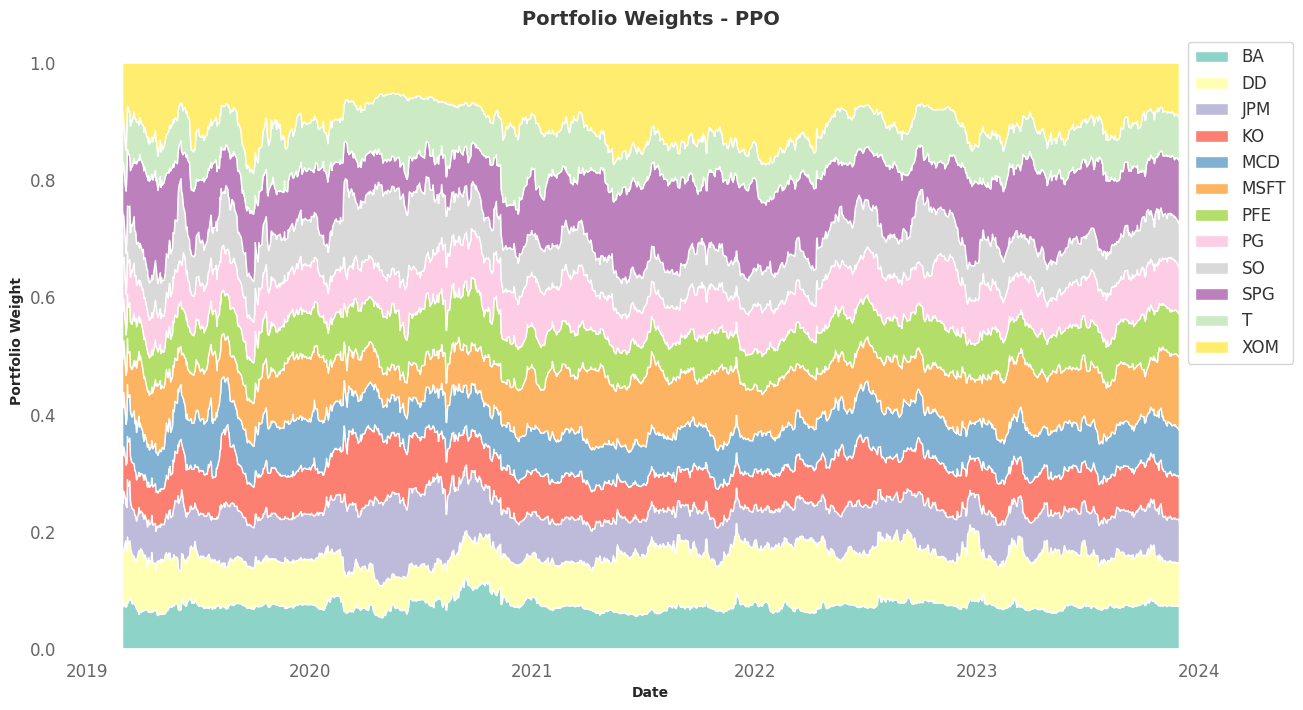

In [59]:
# Portfolio Weights - PPO
plt.figure(figsize = (15, 8))
colors = sns.color_palette("Set3", len(df_ppo_actions.columns))     # or "husl", "Paired"

plt.stackplot(df_ppo_actions.index, df_ppo_actions.values.T, labels=df_ppo_actions.columns, colors=colors)
plt.xlabel('Date', fontweight = 'bold', fontsize = 10)
plt.ylabel('Portfolio Weight', fontweight = 'bold', fontsize = 10)
plt.title('Portfolio Weights - PPO', fontweight = 'bold', fontsize = 14)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.06, 1))
#plt.legend(loc = 'best')
plt.grid(False)

plt.show()

Looking at the **Time Evolution**, meaning **how** the portfolio *weights* of different assets *change* over time, it is possible to track the **shifts** in allocation and identify periods of *concentration* or *diversification*.

Regarding the **Asset Contribution**, the *height* of each colored area at a specific date indicates the *proportion* of the portfolio invested in that particular asset. This helps in understanding the relative **importance** of each *asset* in the portfolio.

Relating to the *dynamics* of portfolio management, any significant **changes** or **trends** in the portfolio weights can provide insights into the strategy employed in managing the portfolio over time.

Inpsecting for **Diversification**, gaps or *variations* in the stacked **areas** can suggest periods of *rebalancing* or adjustments in the portfolio's asset *allocation*, indicating potential changes in the investment strategy.

# 5. **COMPARISON**

In [60]:
# Convert DF to a TS
def convert_daily_return_to_ts(df):
    return ( pd.Series(df.daily_return)
                .rename(df.date)
            )
a2c_strat = convert_daily_return_to_ts(df_daily_return)
ppo_strat = convert_daily_return_to_ts(df_ppo_daily_return)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x1000 with 0 Axes>

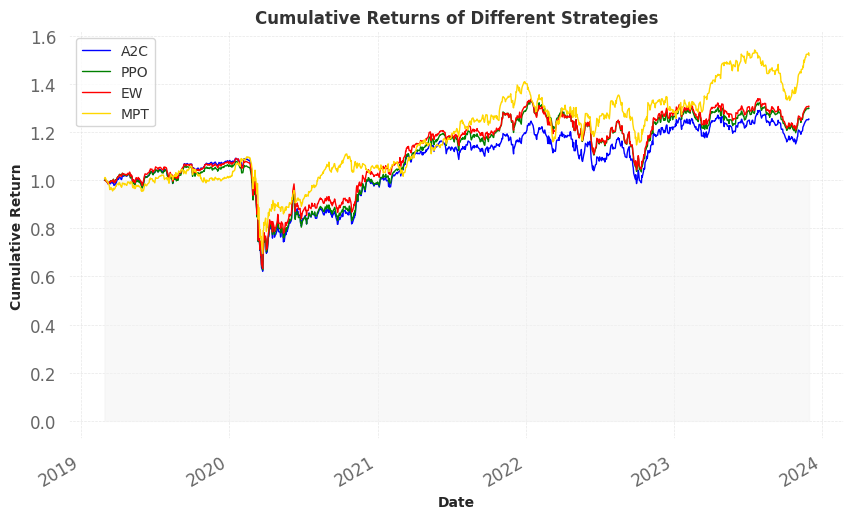

In [61]:
strategy_returns = {
    'A2C': a2c_strat,
    'PPO': ppo_strat,
    'EW': ew_portfolio_returns,
    'MPT': portfolio_performance_series
}

df_strategy_returns = pd.DataFrame(strategy_returns)

# Cumulative Returns of Different Strategies
plt.figure(figsize=(15, 10))

colors = ['blue', 'green', 'red', 'gold']
(df_strategy_returns + 1).cumprod().plot(color=colors, linewidth=1)

plt.title('Cumulative Returns of Different Strategies', fontweight='bold', fontsize=12)
plt.xlabel('Date', fontweight = 'bold', fontsize = 10)
plt.ylabel('Cumulative Return', fontweight = 'bold', fontsize = 10)
plt.legend(fontsize = 10, loc = 'upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.fill_between(df_strategy_returns.index, 0, 1, color='#f2f2f2', alpha=0.5)

plt.show()


Inspecting the results, we can infer that the **RL** algorithms **outperformed** the Equal-Weights strategy. Being more precise, in various periods RL-based portfolio optimization models **outperformed** all benchmark strategies (including MVVO).

## *Actor Critic - EW*

Using the **full** function from the **qs.reports** module, let's generate a set of ***performance*** *metrics* and *visualizations* for the Actor-Critic (**A2C**) strategy compared to the equal-weighted (**EW**) strategy:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-03-01   2019-03-01
End Period                 2023-11-29   2023-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          30.8%        25.3%
CAGR﹪                     3.98%        3.33%

Sharpe                     0.37         0.32
Prob. Sharpe Ratio         78.56%       75.67%
Smart Sharpe               0.33         0.29
Sortino                    0.51         0.45
Smart Sortino              0.46         0.4
Sortino/√2                 0.36         0.32
Smart Sortino/√2           0.32         0.29
Omega                      1.07         1.07

Max Drawdown               -41.94%      -43.03%
Longest DD Days            559          416
Volatility (ann.)          22.23%       23.25%
R^2                        0.99         0.99
Information Ratio          -0.01        -0.0

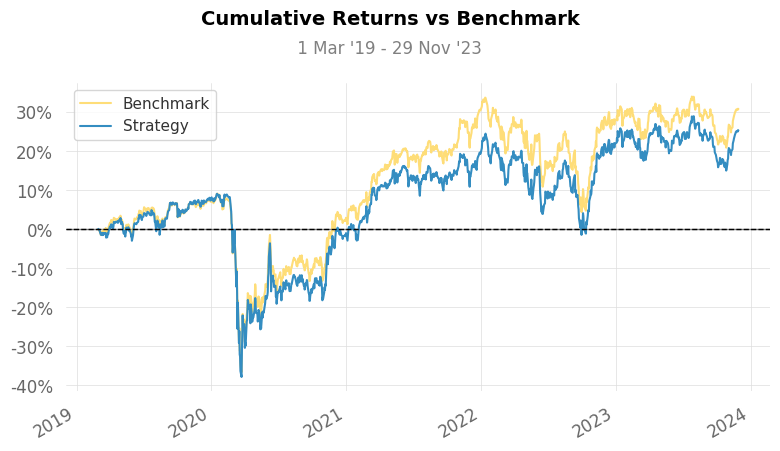

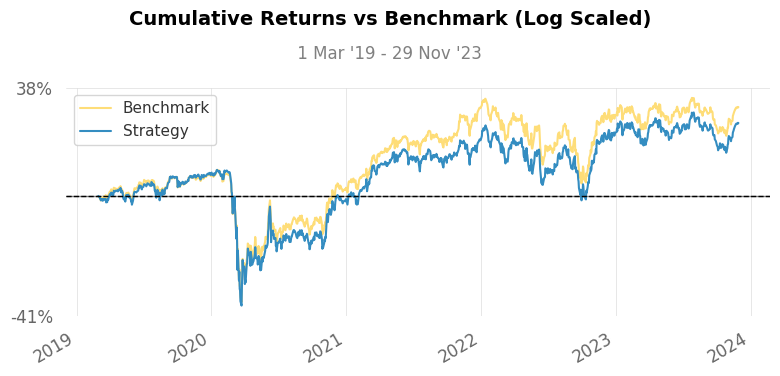

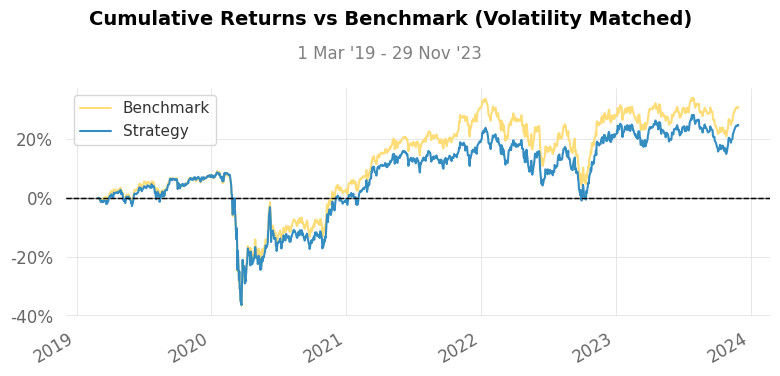

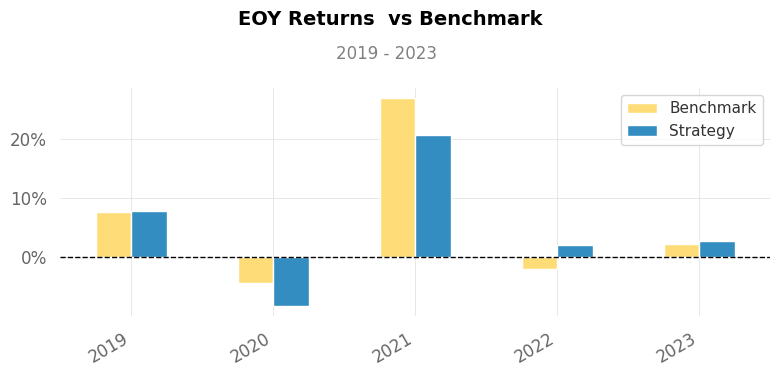

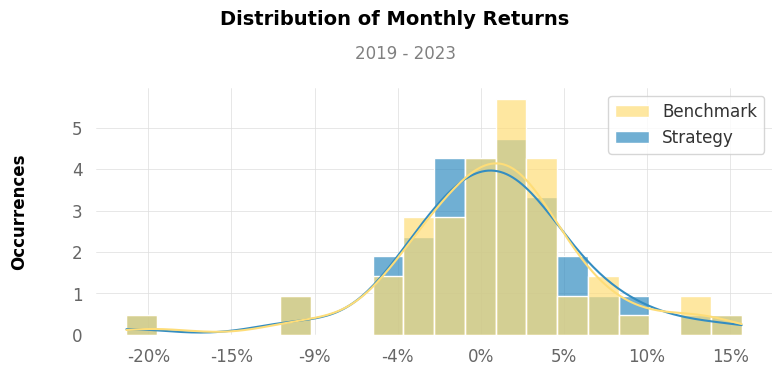

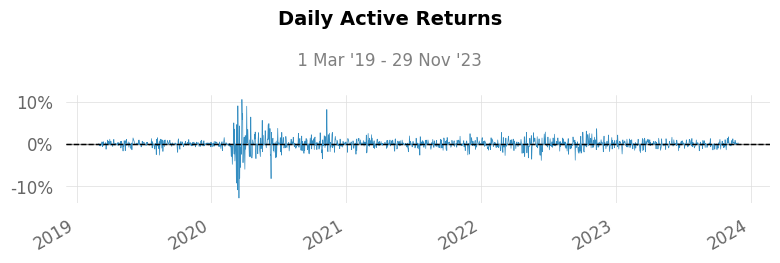

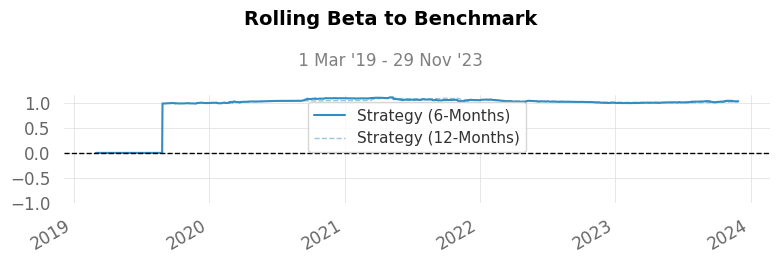

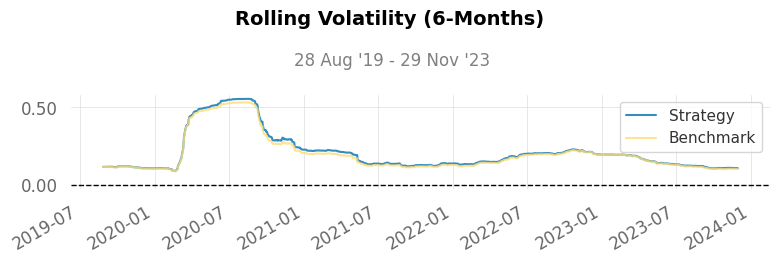

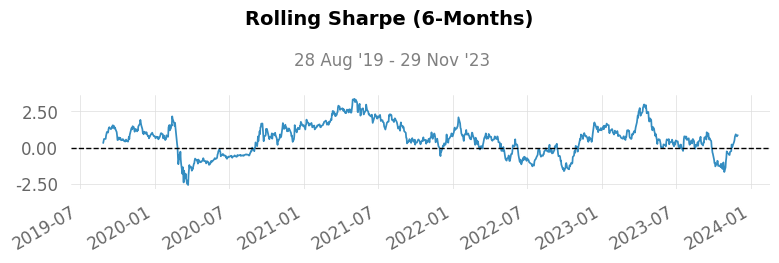

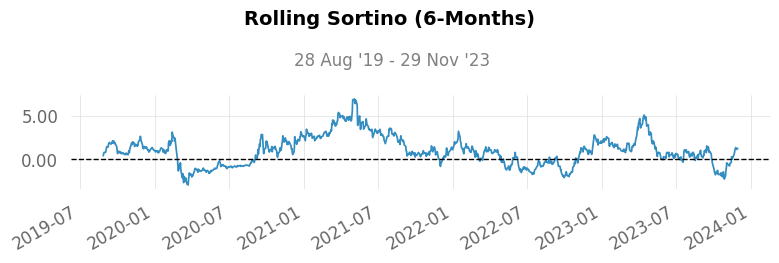

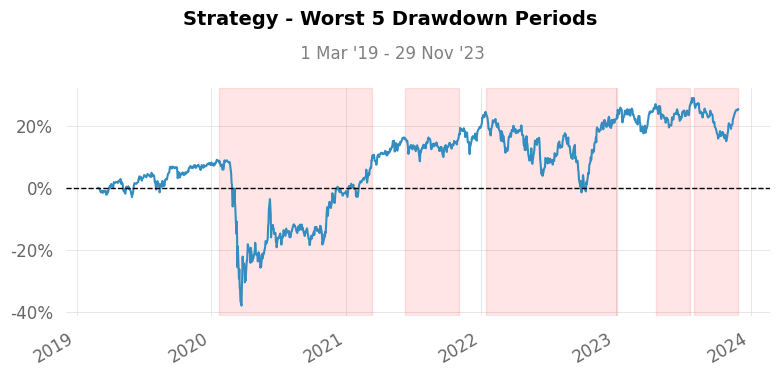

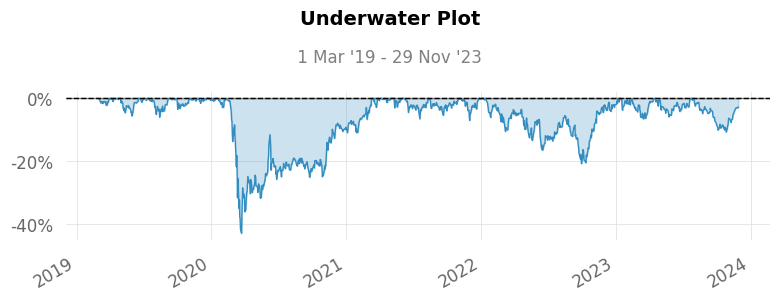

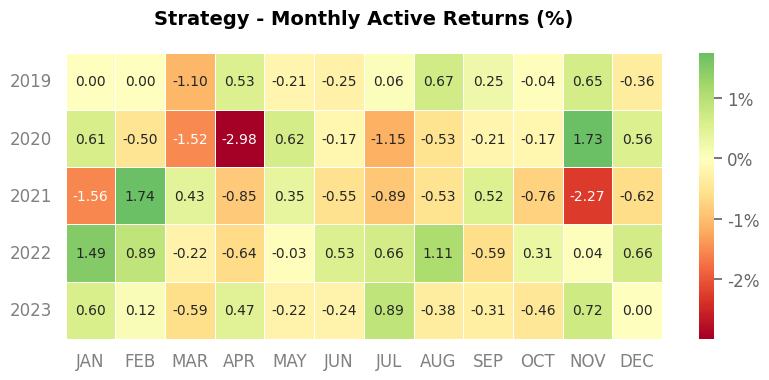

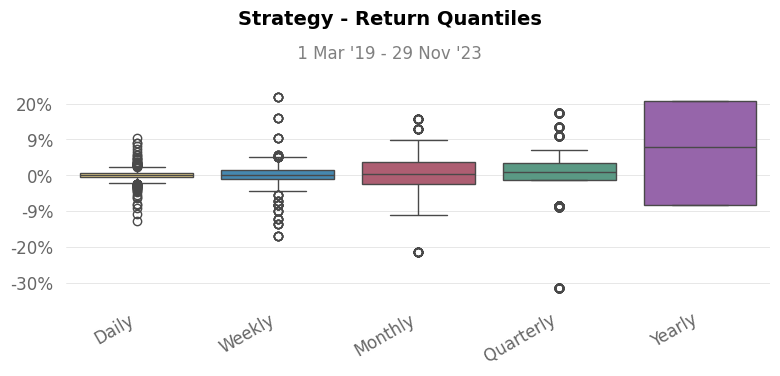

In [62]:
# A2C - EQUAL WEIGHTS STRATEGY
qs.reports.full(a2c_strat,
               benchmark = ew_portfolio_returns,
                title = 'Actor-Critic Strategy',
                mode = "basic",
                prepare_returns = False)

## *Actor Critic - MMVO*

Let's generate a set of ***performance*** *metrics* and *visualizations* for the Actor-Critic (**A2C**) strategy compared to the modern portfolio theory (**MPT**):

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-02-28   2019-02-28
End Period                 2023-11-29   2023-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          50.95%       25.4%
CAGR﹪                     6.16%        3.34%

Sharpe                     0.52         0.32
Prob. Sharpe Ratio         86.94%       75.72%
Smart Sharpe               0.47         0.29
Sortino                    0.73         0.45
Smart Sortino              0.66         0.4
Sortino/√2                 0.52         0.32
Smart Sortino/√2           0.46         0.29
Omega                      1.07         1.07

Max Drawdown               -36.63%      -43.03%
Longest DD Days            462          416
Volatility (ann.)          20.8%        23.24%
R^2                        0.58         0.58
Information Ratio          -0.01        -0.0

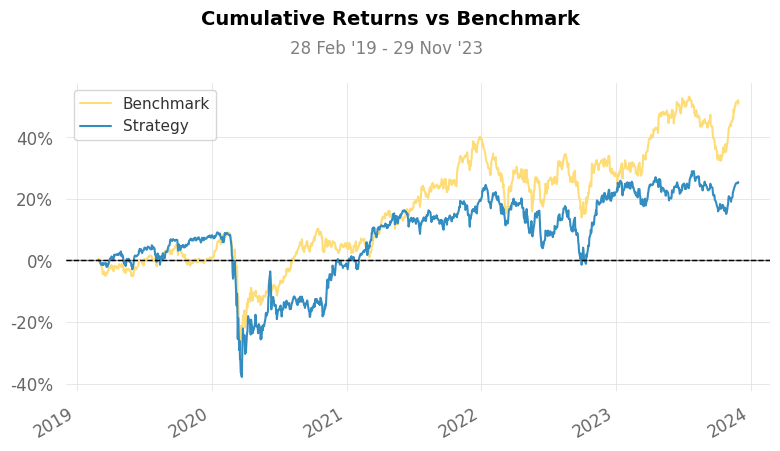

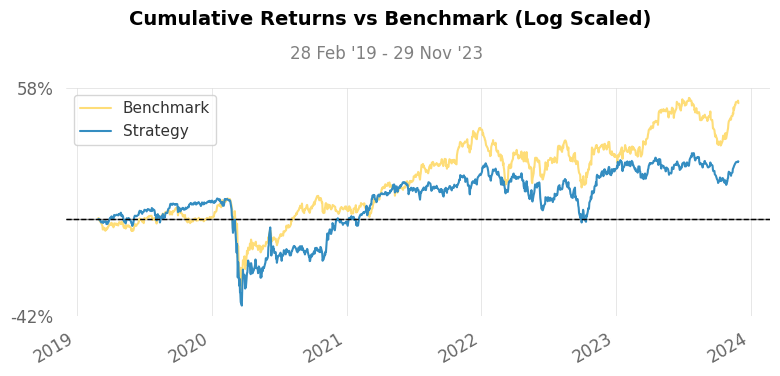

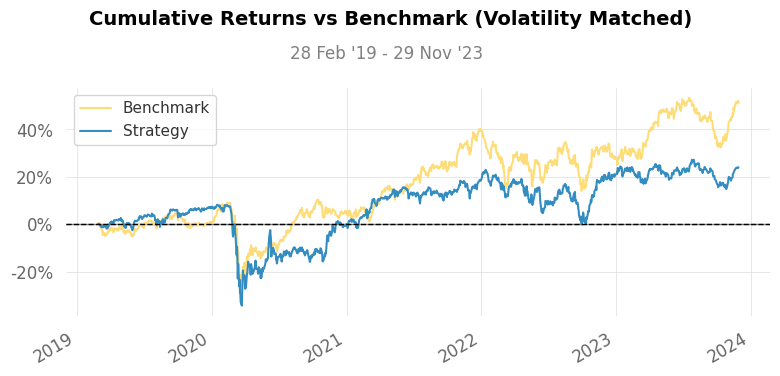

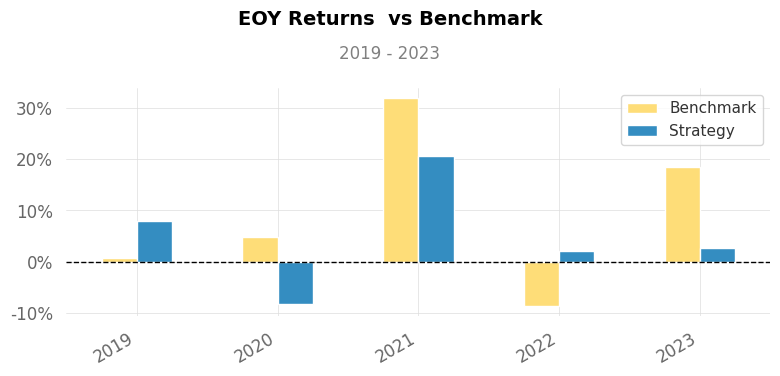

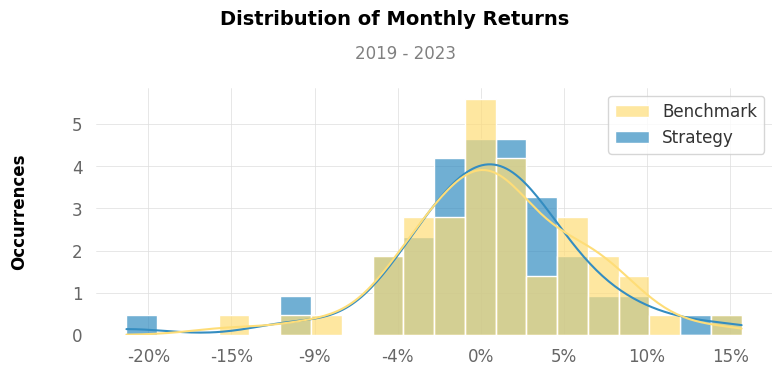

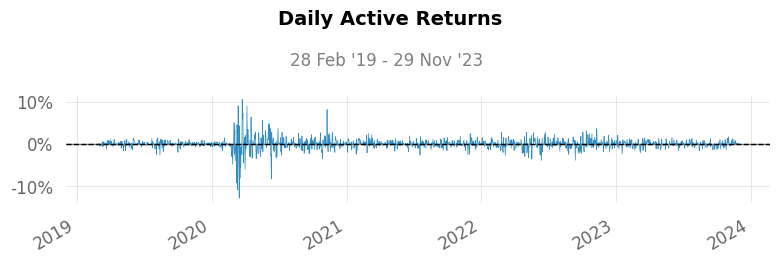

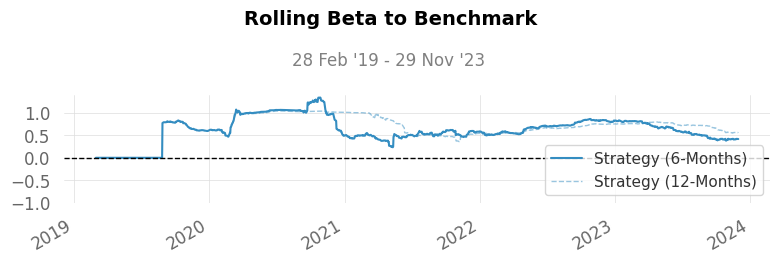

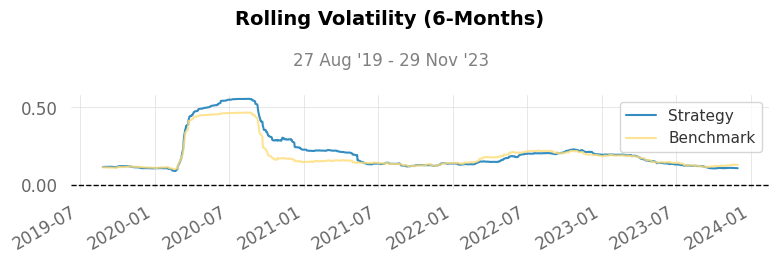

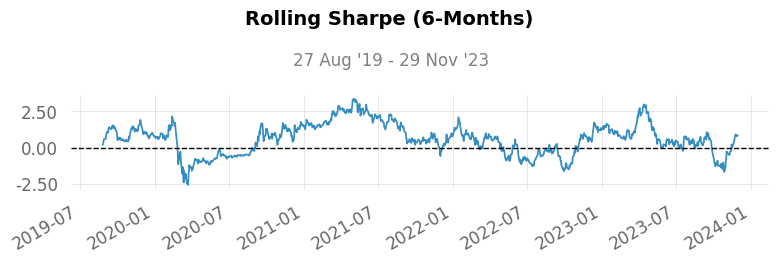

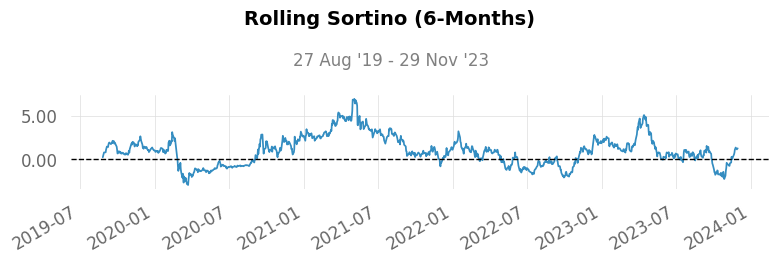

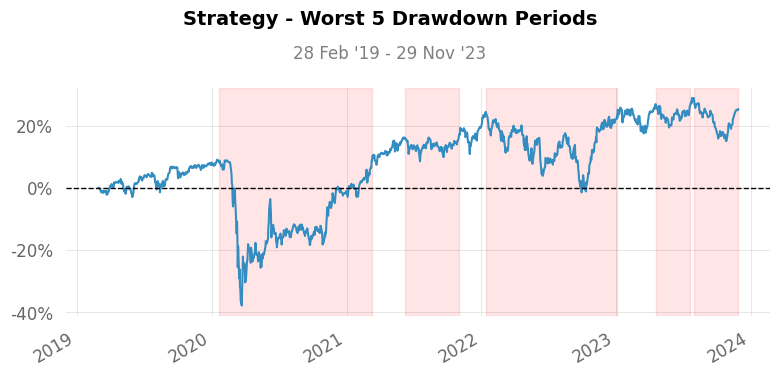

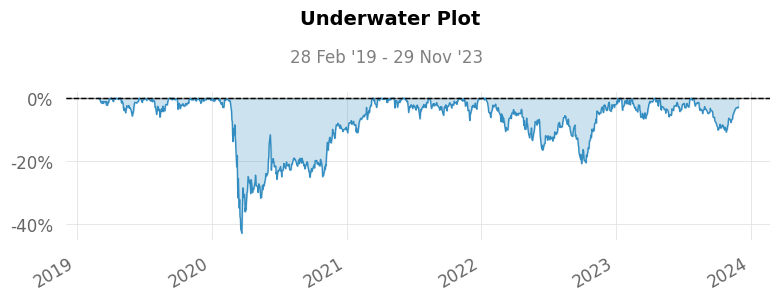

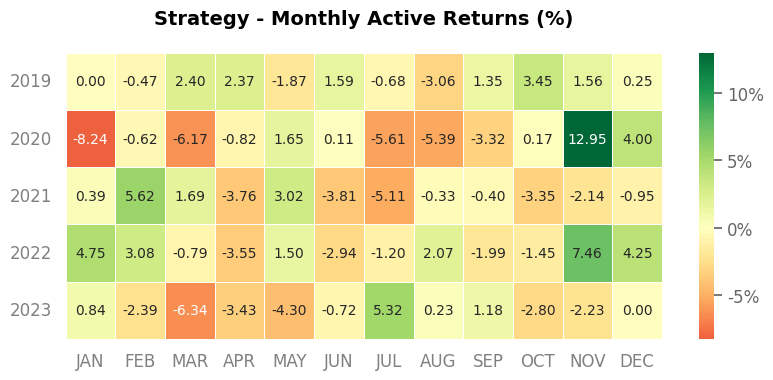

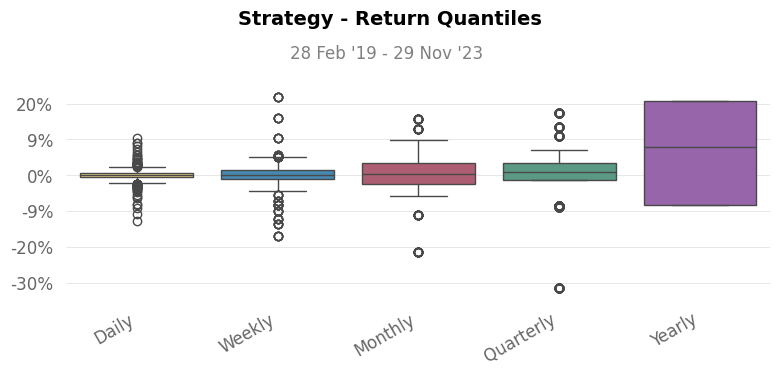

In [63]:
# A2C - MPT
qs.reports.full(a2c_strat,
               benchmark = portfolio_performance_series,
                title = 'Actor-Critic Strategy',
                   mode = "basic",
                   prepare_returns = False)

## *PPO - EW*

Using the **full** function from the **qs.reports** module, let's generate a set of ***performance*** *metrics* and *visualizations* for the Proximal Policy Optimization (**PPO**) strategy compared to the equal-weighted (**EW**) strategy:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-03-01   2019-03-01
End Period                 2023-11-29   2023-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          30.8%        29.98%
CAGR﹪                     3.98%        3.88%

Sharpe                     0.37         0.36
Prob. Sharpe Ratio         78.56%       78.21%
Smart Sharpe               0.32         0.32
Sortino                    0.51         0.5
Smart Sortino              0.45         0.44
Sortino/√2                 0.36         0.35
Smart Sortino/√2           0.32         0.31
Omega                      1.08         1.08

Max Drawdown               -41.94%      -41.78%
Longest DD Days            559          686
Volatility (ann.)          22.23%       22.22%
R^2                        0.99         0.99
Information Ratio          -0.0         -0.

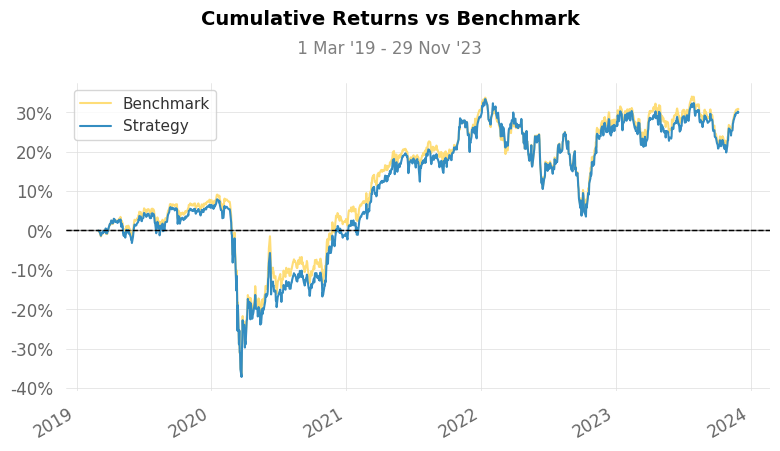

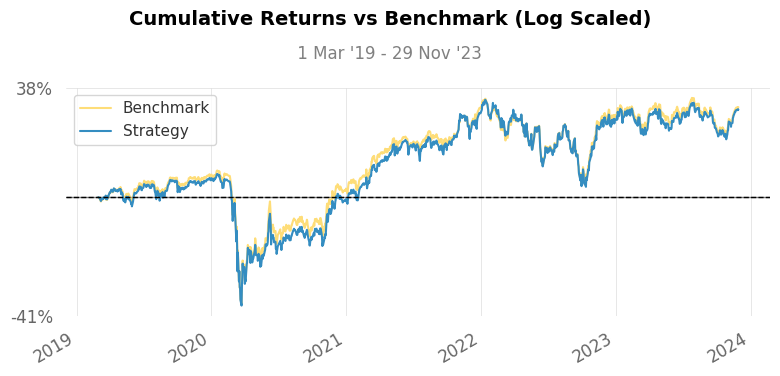

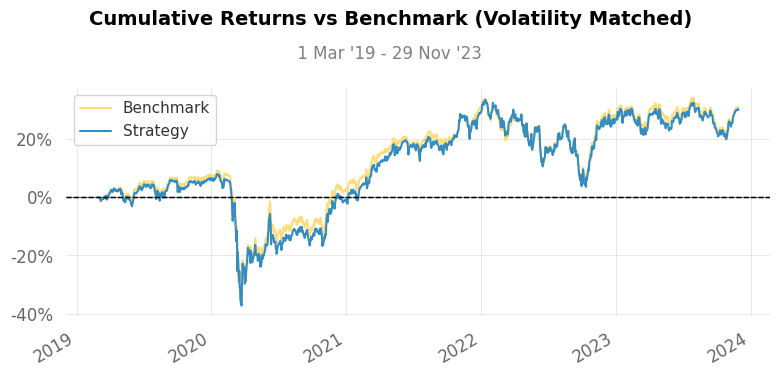

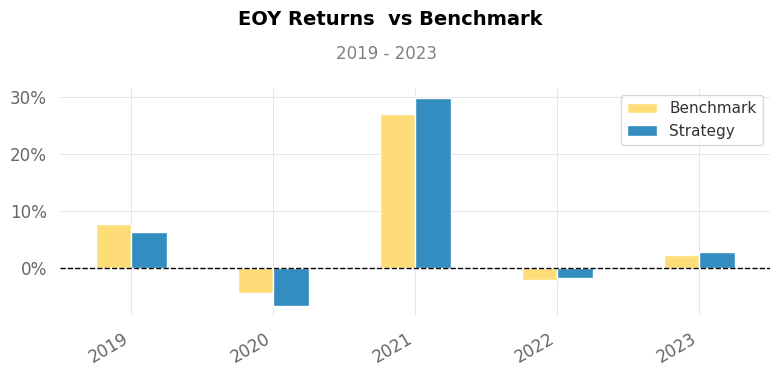

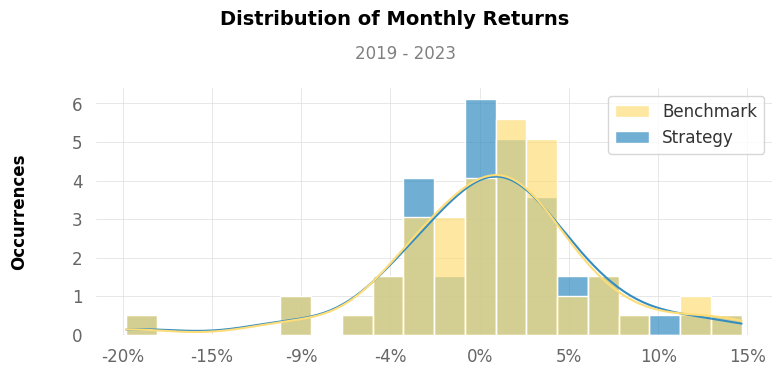

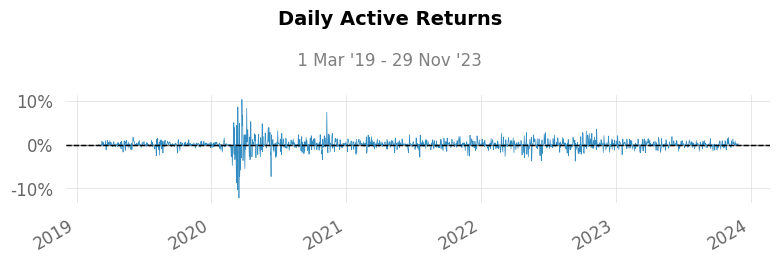

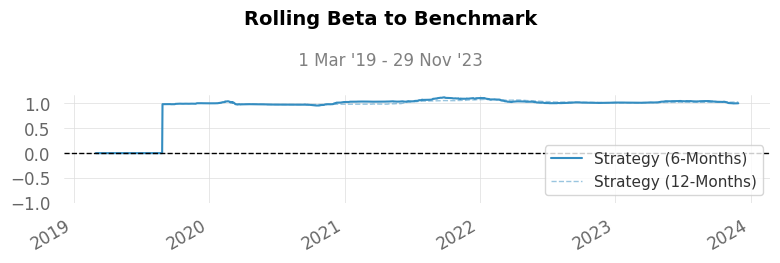

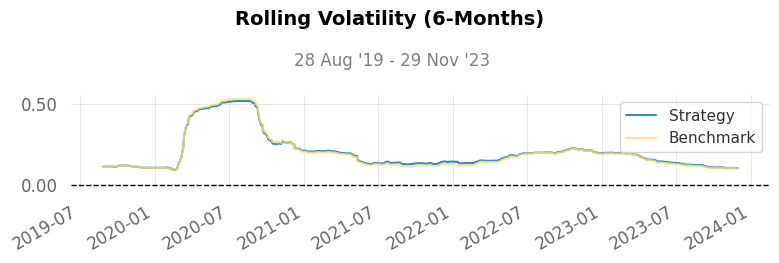

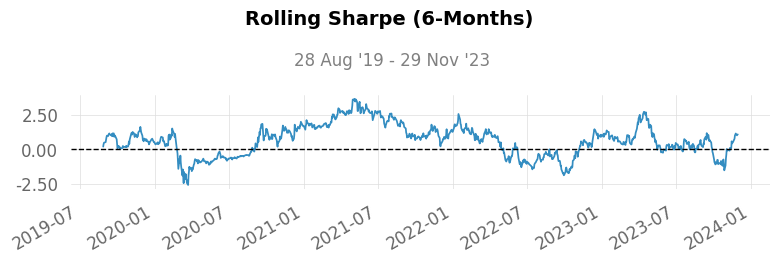

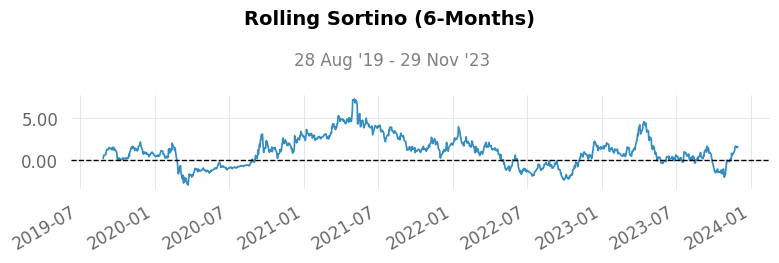

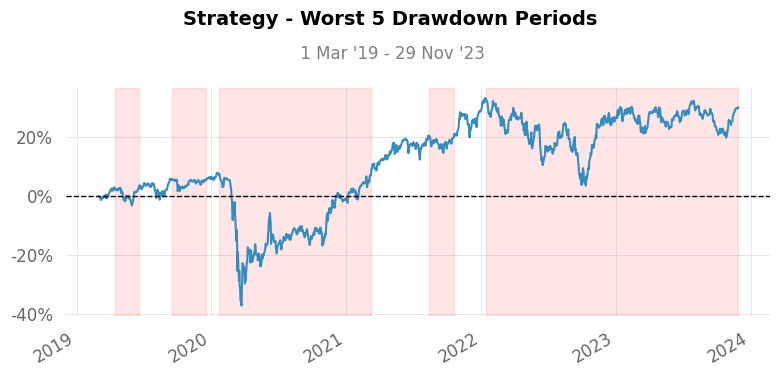

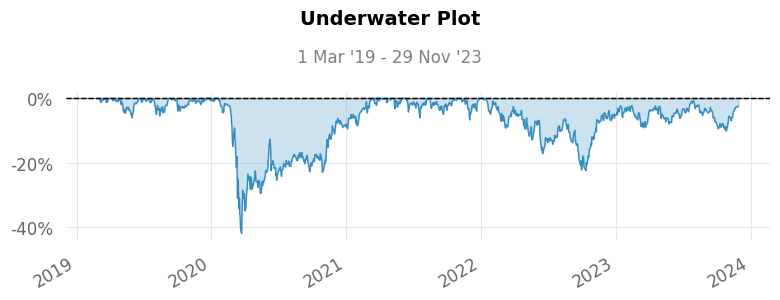

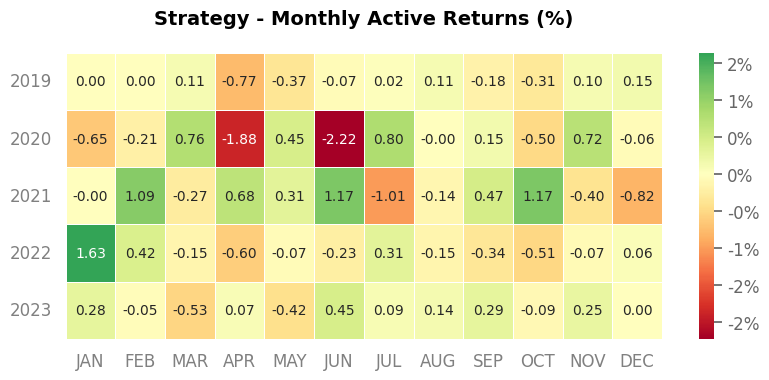

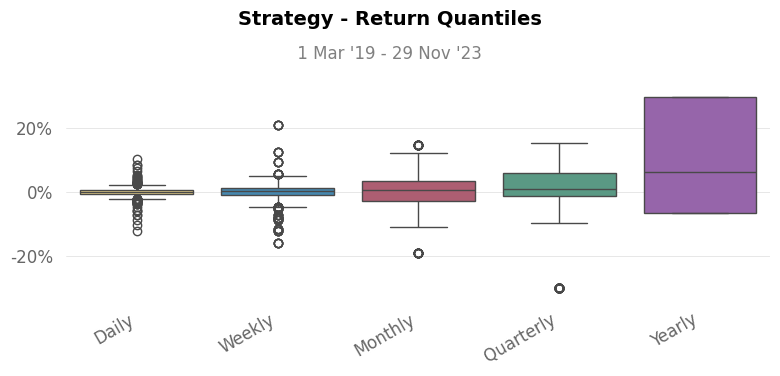

In [64]:
# PPO - EQUAL WEIGHTS STRATEGY
qs.reports.full(ppo_strat,
                benchmark = ew_portfolio_returns,
                title = 'PPO Strategy',
                mode = "basic",
                prepare_returns = False)

## *PPO - MMVO*

Let's generate a set of ***performance*** *metrics* and *visualizations* for the Proximal Policy Optimization (**PPO**) strategy compared to the modern portfolio theory (**MPT**):

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-02-28   2019-02-28
End Period                 2023-11-29   2023-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          50.95%       29.91%
CAGR﹪                     6.16%        3.87%

Sharpe                     0.52         0.36
Prob. Sharpe Ratio         86.94%       78.18%
Smart Sharpe               0.46         0.32
Sortino                    0.73         0.5
Smart Sortino              0.65         0.44
Sortino/√2                 0.52         0.35
Smart Sortino/√2           0.46         0.31
Omega                      1.08         1.08

Max Drawdown               -36.63%      -41.78%
Longest DD Days            462          686
Volatility (ann.)          20.8%        22.21%
R^2                        0.62         0.62
Information Ratio          -0.01        -0.

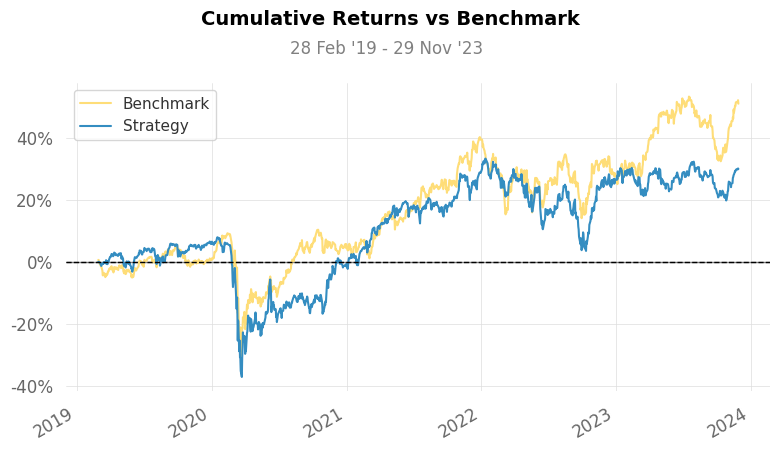

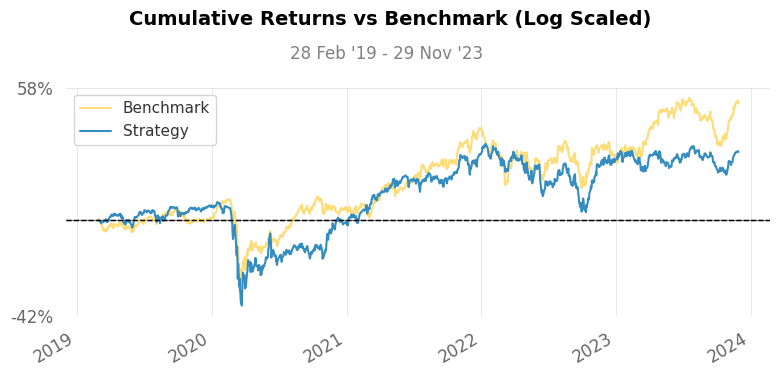

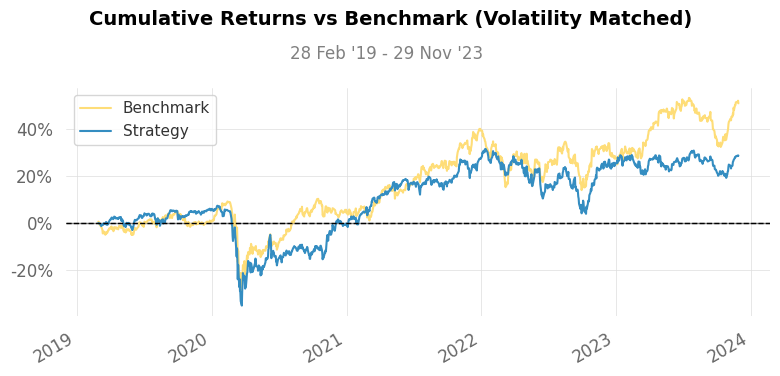

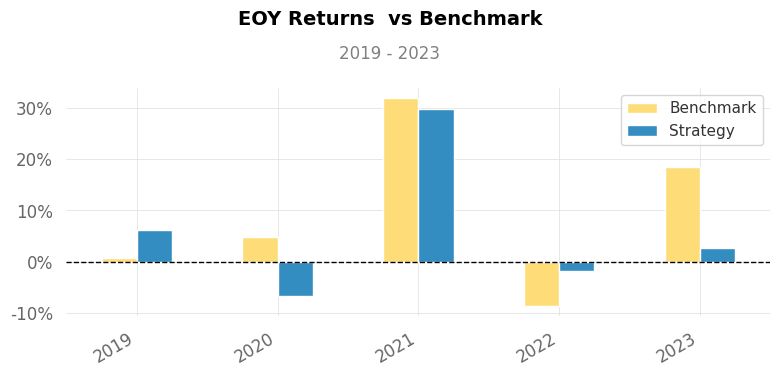

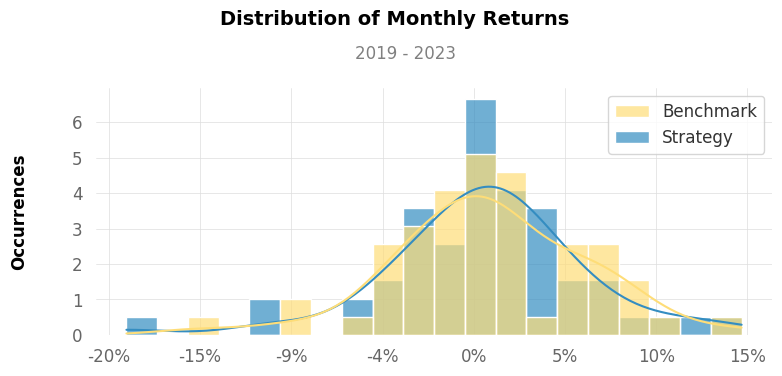

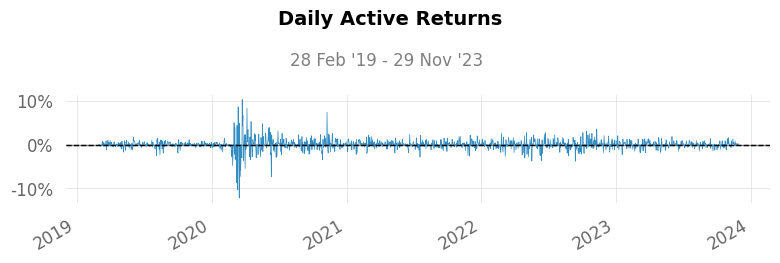

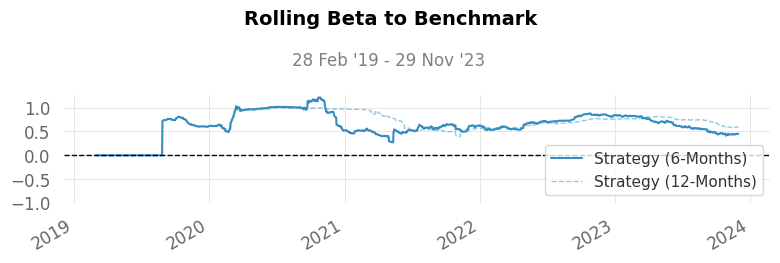

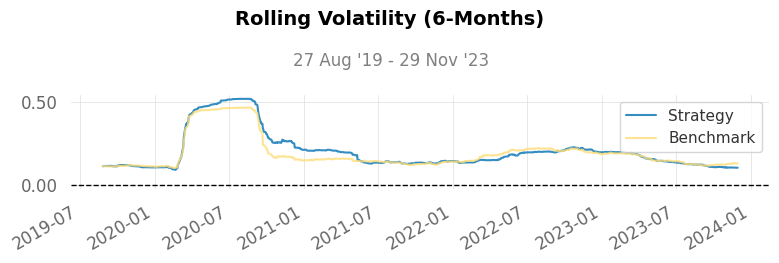

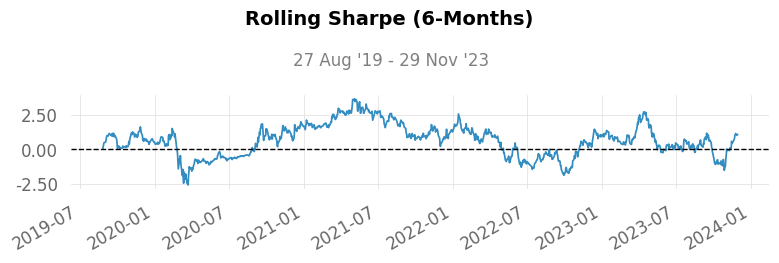

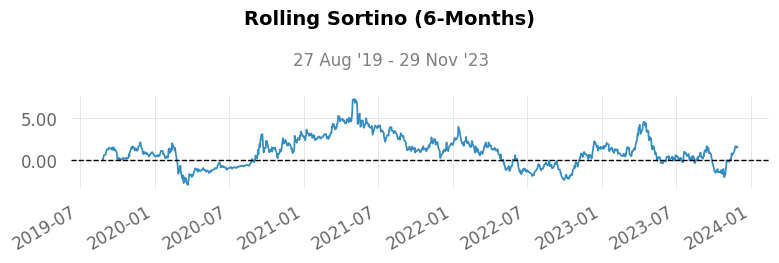

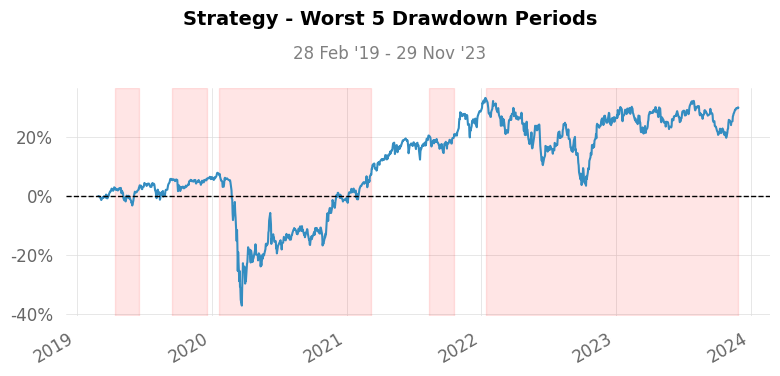

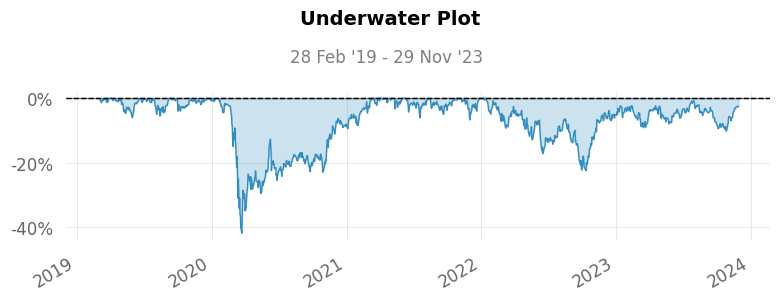

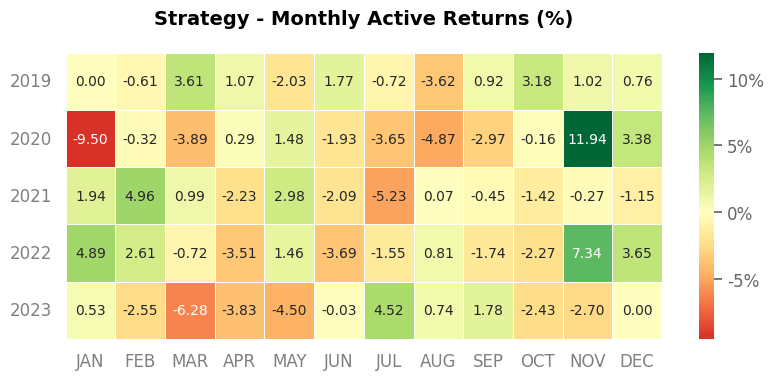

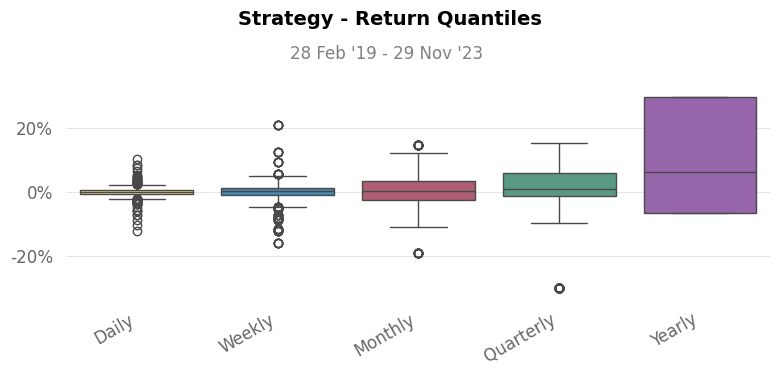

In [65]:
# PPO - MPT
qs.reports.full(ppo_strat,
               benchmark = portfolio_performance_series,
                title = 'PPO Strategy',
                   mode = "basic",
                   prepare_returns = False)

The **MMVO** strategy **outperforms** the others across multiple key perfomance metrics, demostrating superior *risk-adjusted* returns, *downside protection*, overall *profitability* and *resilience*, reaching a cumulative return of **50.95%** and a CAGR of **6.16%**.

Even if Reinforcement Learning algorithms outperfomed the MMVO strategy only in **DD days**, we can conclude that RL-based portfolio optimization models may be able to outperform the EW strategy. In particular:
- **RL's Promise in Portfolio Optimization**:
Demonstrates potential in *adapting* to market changes and *maximizing* returns.
- **Current Limitations**:
Does not include *transaction* costs, which may affect real-world applicability.
- **Expanding Data Sources**:
Utilize company reports, social media, news, and macroeconomic factors for more *informed* and *improved* predictions.